In [ ]:
!pip install adjustText
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import to_rgba
import gzip
from functools import partial
import ast
import dmslogo
import random

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats
from scipy import spatial

import Bio
from Bio import motifs
from operator import itemgetter
import networkx as nx
from networkx.algorithms import bipartite

from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

from adjustText import adjust_text

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

from tqdm.auto import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

No GPU available


In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

class utils():        
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

In [ ]:
#--- BODA library
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

sequence_column_name = 'sequence'
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']
onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(no_controls_df[sequence_column_name].tolist())])
contribution_tensor = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in no_controls_df[contribution_column]])
    contribution_tensor.append(flat_contributions * onehot_sequences)
contribution_tensor = torch.stack(contribution_tensor)

#--- Motif programs
programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/STREME_topic_modeling/BODA_topics.txt',
                         sep='\t', header=0, index_col=0)
programs = programs / programs.sum(axis=0)
program_columns = [str(i) for i in range(13)]

#--- Sequence programs
seq_programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/STREME_topic_modeling/BODA_sequence_topics.txt',
                         sep='\t', header=0, index_col=0)
seq_programs = seq_programs.reset_index()
seq_programs = seq_programs.rename({'id':'ID'}, axis=1)

#--- STREME motifs
boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_ultimate_merge.txt', sep=" ", low_memory=False)
boda2_streme_tfs.at[0, 'contribution_HepG2'] = boda2_streme_tfs.iloc[0]['contribution_HepG2'] / 2

# boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_contributions.txt', sep=" ", low_memory=False)
# boda2_streme_tfs.at[0, 'contribution_HepG2'] = boda2_streme_tfs.iloc[0]['contribution_HepG2'] / 2
# short_names_with_distinction = [f'S-{i+1} ({short_name})' for i, short_name in enumerate(boda2_streme_tfs['Target_ID_short'].tolist())]
# boda2_streme_tfs['Target_ID_short'] = short_names_with_distinction

boda2_streme_tfs_logos = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/streme_TFs_processed.txt', sep=" ", low_memory=False)
df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    boda2_streme_tfs_logos[df_array_column] = boda2_streme_tfs_logos.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)
    
#--- FIMO
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

#--- Colormap
# index2color = { i: c for i, c in zip(
#     range(13),
#     ['#993404', '#fddaec', '#fed9a6', '#D500FF', '#ccebc5', '#253494', '#ffffcc', '#e5d8bd', '#FF0004', '#41b6c4', '#decbe4', '#d95f0e', '#fe9929']
# ) }
# colors = [index2color[int(idx)] for idx in programs[program_columns].idxmax(axis=1).tolist()]

hepg2_1 = '#993404'
hepg2_2 = '#d95f0e'
hepg2_3 = '#fe9929'

k562_1 = '#253494'
k562_2 = '#41b6c4'

sknsh_1 = '#D500FF' # '#FF00D0' # 
sknsh_2 = '#FF0004'
sknsh_3 = '#FF5CB0' # #fddaec

extra_1 = '#fed9a6'
extra_2 = '#ccebc5'
extra_3 = '#ffffcc'
extra_4 = '#e5d8bd'
extra_5 = '#decbe4'

blank   = '#f2f2f2'

color_order = [hepg2_1,sknsh_3,extra_1,sknsh_1,extra_2,k562_1,extra_3,extra_4,sknsh_2,k562_2,extra_5,hepg2_2,hepg2_3] 
colors = [mpl.colors.to_rgba(x) for x in color_order]
pal = sns.color_palette(color_order)

pal

  0%|          | 0/117900 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[(0.6, 0.20392156862745098, 0.01568627450980392),
 (1.0, 0.3607843137254902, 0.6901960784313725),
 (0.996078431372549, 0.8509803921568627, 0.6509803921568628),
 (0.8352941176470589, 0.0, 1.0),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (0.1450980392156863, 0.20392156862745098, 0.5803921568627451),
 (1.0, 1.0, 0.8),
 (0.8980392156862745, 0.8470588235294118, 0.7411764705882353),
 (1.0, 0.0, 0.01568627450980392),
 (0.2549019607843137, 0.7137254901960784, 0.7686274509803922),
 (0.8705882352941177, 0.796078431372549, 0.8941176470588236),
 (0.8509803921568627, 0.37254901960784315, 0.054901960784313725),
 (0.996078431372549, 0.6, 0.1607843137254902)]

In [ ]:
programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/STREME_topic_modeling/BODA_topics.txt',
                         sep='\t', header=0, index_col=0)
programs = programs / programs.sum(axis=0)

program_columns = [str(i) for i in range(13)]
#programs[program_columns] = F.softmax(torch.Tensor(programs[program_columns].values), dim=0).numpy()

In [ ]:
#--- Merge motif info
merged_tf_df = boda2_streme_tfs.copy() #.merge(programs, on='motif_id').reset_index(drop=True)
merged_tf_df = merged_tf_df.drop([22, 30, 56, 79, 84], axis=0)
merged_tf_df['color'] = [color_order[int(idx)] for idx in merged_tf_df[program_columns].idxmax(axis=1).tolist()]

#--- Merge seq info
merged_seq_df = boda2_df.merge(seq_programs, on='ID', how='inner').reset_index(drop=True)

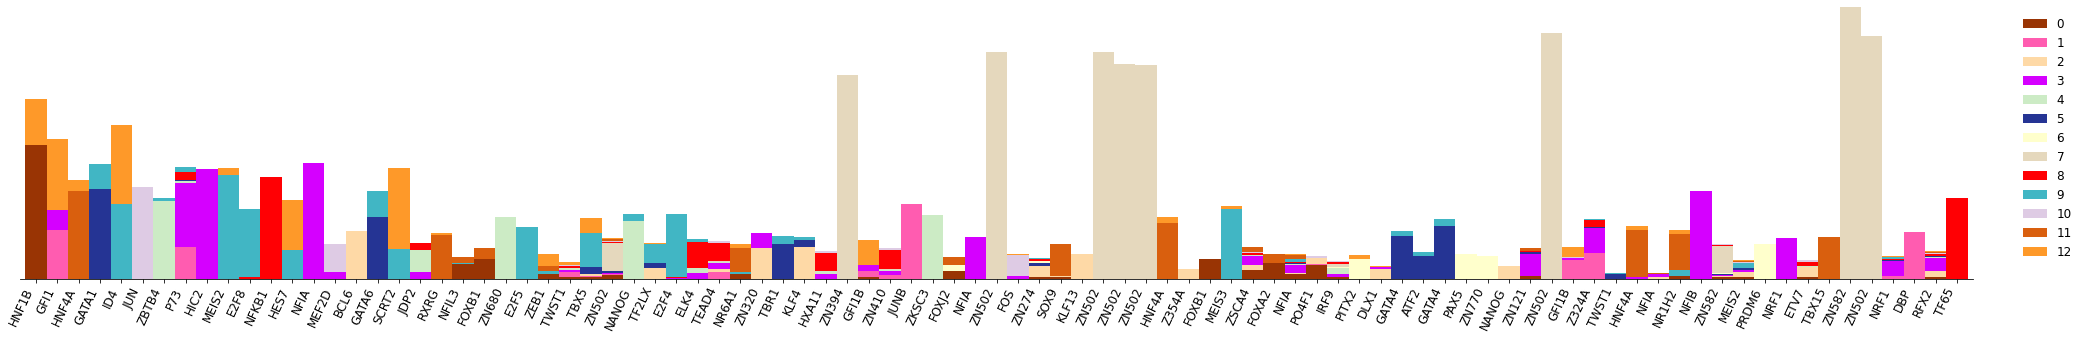

In [ ]:
#--- Motif program weights
ax = merged_tf_df[program_columns].plot.bar(stacked=True, 
                    figsize=(35,5), 
                    width=1,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(merged_tf_df['Target_ID_short'].tolist(), rotation=65, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.02,1), fontsize='large', labelspacing=0.5, frameon=False)
ax.set_yticks([])
plt.show()

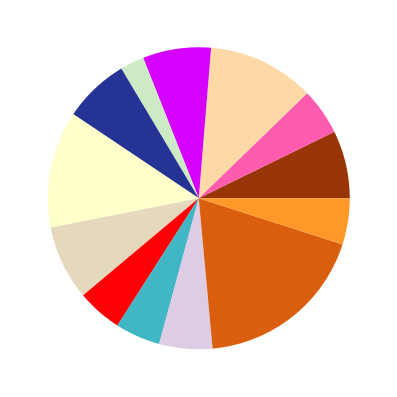

In [ ]:
temp_df = merged_seq_df[merged_seq_df['method'] == 'DHS']

temp_weights = temp_df[program_columns].sum().to_numpy()
original_sum = temp_weights.sum()
temp_weights = temp_weights/original_sum

plt.figure(figsize=(5,5), dpi=100)
plt.pie(x=temp_weights, colors=pal)
plt.show()

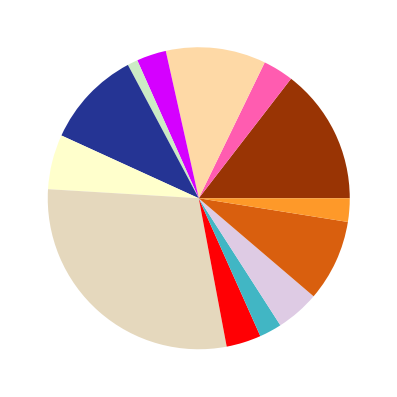

In [ ]:
temp_df = merged_seq_df[merged_seq_df['method'] == 'gs']

temp_weights = temp_df[program_columns].sum().to_numpy()
original_sum = temp_weights.sum()
temp_weights = temp_weights/original_sum

plt.figure(figsize=(5,5), dpi=100)
plt.pie(x=temp_weights, colors=pal)
plt.show()

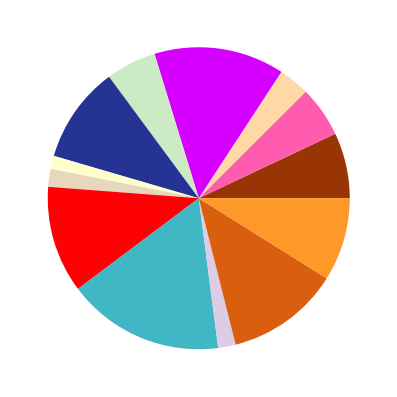

In [ ]:
temp_df = merged_seq_df[(merged_seq_df['method'] == 'fsp') & (merged_seq_df['round'] == 0)]

temp_weights = temp_df[program_columns].sum().to_numpy()
original_sum = temp_weights.sum()
temp_weights = temp_weights/original_sum

plt.figure(figsize=(5,5), dpi=100)
plt.pie(x=temp_weights, colors=pal)
plt.show()

# Explore a single sequence

In [ ]:
#single_seq_id = '20211212_75659__621411__391::fsp__sknsh__0'
#single_seq_id = '20211206_24503__33072627__1397::al__hepg2__0'
#single_seq_id = '20211207_212124__46481152__2927::al__sknsh__0'
single_seq_id = '20211206_24503__33072627__1223::al__hepg2__0'

single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]

test_str = single_seq_df['sequence'].item()
test_onehot = utils.dna2tensor(test_str).view(4,-1)

contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

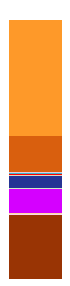

In [ ]:
ax = single_seq_df[program_columns].plot.bar(stacked=True, width=10, figsize=(1,5),
                        color=pal, linewidth=0.0, legend=False)
plt.axis('off')
plt.show()

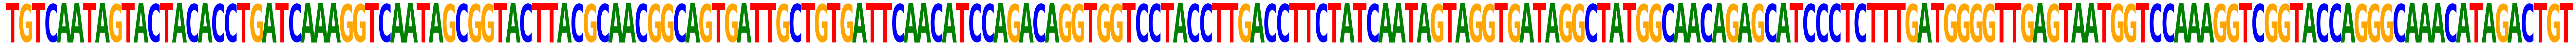

In [ ]:
plot_tensor = test_onehot
fig, ax = matrix_to_dms(plot_tensor, y_max=1,
                        fontaspect=0.5, widthscale=2, axisfontscale=0.6, heightscale=1)
plt.axis('off')
plt.show()

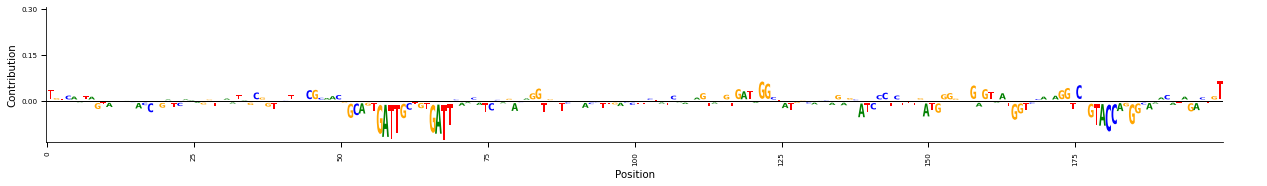

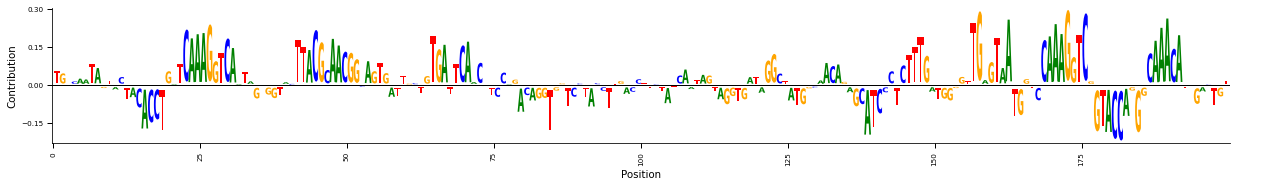

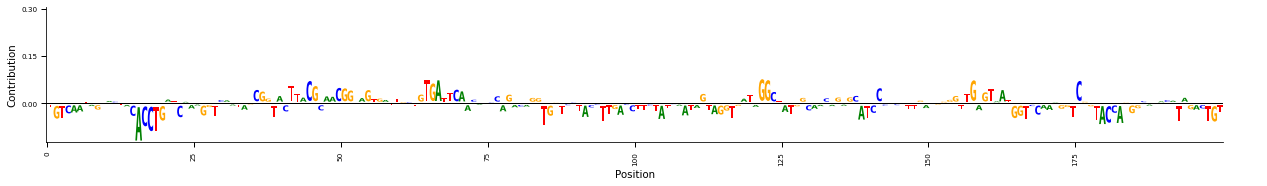

In [ ]:
cell_types = ['K562', 'HepG2', 'SKNSH']

y_max = contribution_tensor.max()
for i in range(3):
    plot_tensor = contribution_tensor[i, ...]
    fig, ax = matrix_to_dms(plot_tensor, y_max=y_max,
                            fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=1)
    #plt.axis('off')
    plt.xticks(np.arange(0, 200, 25), labels=np.arange(0, 200, 25))
    plt.xlabel('Position')
    plt.ylabel('Contribution')
    #ax.spines['bottom'].set_visible(False)
    savepath = f'/content/drive/MyDrive/figures/contribution_scores_examples/{single_seq_id}_contribution_scores_{cell_types[i]}.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

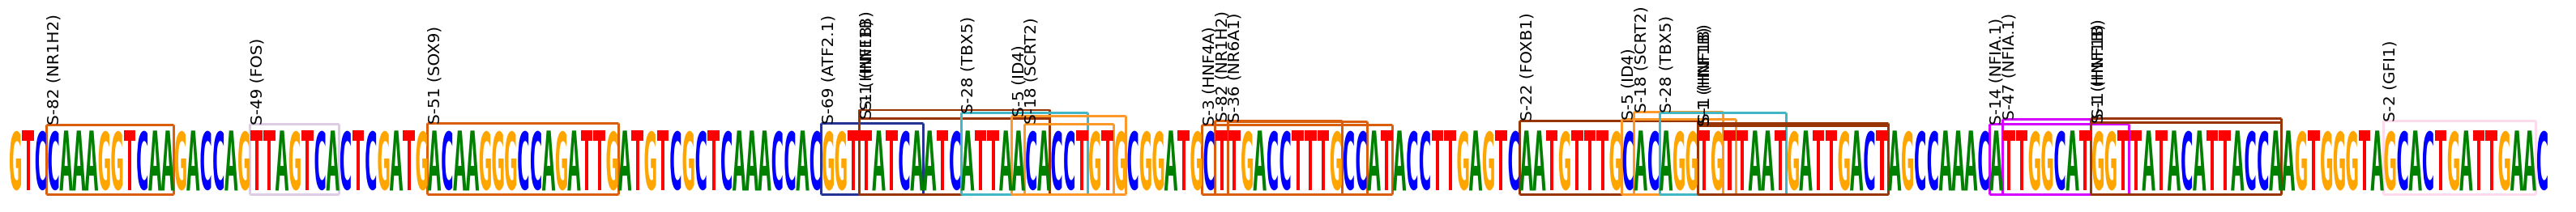

In [ ]:
seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
seq_contributions = test_onehot #contribution_tensor
y_max = seq_contributions.max()

color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

find_motif_names  = []
motifs_start_ends = []
orientations      = []
cover_set         = set()
passing_idxs = []
all_motif_contributions = []
num_hits = len(seq_scan_df)
for i in range(num_hits):
    hit_row = seq_scan_df.iloc[i]
    m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
    motif_range = set(np.arange(m_start, m_end))
    motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
    pos_contribution = motif_contributions.max()
    neg_contribution = motif_contributions.min()
    contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

    find_motif_names.append(hit_row['motif_id'])
    motifs_start_ends.append((m_start, m_end))
    orientations.append(hit_row['strand'])
    cover_set = cover_set | motif_range
    passing_idxs.append(i)
    all_motif_contributions.append(motif_contributions)

#for i in range(0,3):
# i = 1
# matrix_plot = seq_contributions[i, ...]
matrix_plot = seq_contributions
y_cushion = 0.3
contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                    for m_start, m_end in motifs_start_ends]
fig, ax = matrix_to_dms(matrix_plot, y_max=y_max + y_cushion, colors=['green','blue','orange','red'], \
                    heightscale=0.8, fontaspect=0.55)
# fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
#                     fontaspect=0.5, widthscale=2, axisfontscale=0.6, heightscale=1)
for idx, motif_name in enumerate(find_motif_names):
    random_eps = random.uniform(0.05, y_cushion)
    color = color_dict[motif_name]
    plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1] + random_eps, linestyles='solid', colors=color, linewidth=3.0)
    plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1] + random_eps, linestyles='solid', colors=color, linewidth=3.0)
    plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
    plt.hlines(contrib_min_maxs[idx][1] + random_eps, motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

    text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
    x = motifs_start_ends[idx][0] 
    y = contrib_min_maxs[idx][1] + 0.05 + random_eps 
    plt.text(x, y, text, fontsize=20, rotation=90)  
plt.axis('off')
plt.show()  

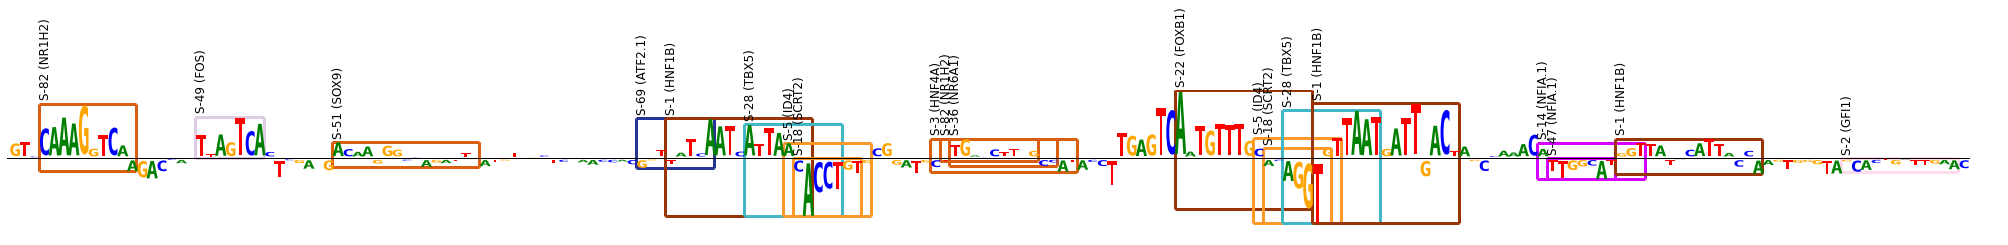

In [ ]:
seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
seq_contributions = contribution_tensor
y_max = seq_contributions.max()

color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

find_motif_names  = []
motifs_start_ends = []
orientations      = []
cover_set         = set()
passing_idxs = []
all_motif_contributions = []
num_hits = len(seq_scan_df)
for i in range(num_hits):
    hit_row = seq_scan_df.iloc[i]
    m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
    motif_range = set(np.arange(m_start, m_end))
    motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
    pos_contribution = motif_contributions.max()
    neg_contribution = motif_contributions.min()
    contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

    find_motif_names.append(hit_row['motif_id'])
    motifs_start_ends.append((m_start, m_end))
    orientations.append(hit_row['strand'])
    cover_set = cover_set | motif_range
    passing_idxs.append(i)
    all_motif_contributions.append(motif_contributions)

#for i in range(0,3):
i = 1
matrix_plot = seq_contributions[i, ...]
contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                    for m_start, m_end in motifs_start_ends]
# fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
#                     heightscale=0.8, fontaspect=0.55)
fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                    fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
for idx, motif_name in enumerate(find_motif_names):
    color = color_dict[motif_name]
    plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
    plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
    plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
    plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

    text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
    x = motifs_start_ends[idx][0] 
    y = contrib_min_maxs[idx][1] + 0.05  
    plt.text(x, y, text, fontsize=12, rotation=90)  
plt.axis('off')
plt.show()  

In [ ]:
boda2_streme_tfs.iloc[5]

motif_id                    6-DATGASTCATH
motif_alt_id                     STREME-6
num_instances                       27474
contribution_K562                1.228746
contribution_HepG2               1.327934
contribution_SKNSH               1.552761
Target_ID             JUN_HUMAN.H11MO.0.A
Target_ID_short                 S-6 (JUN)
Name: 5, dtype: object

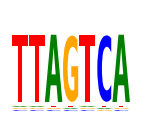

In [ ]:
matrix_to_dms(torch.Tensor(boda2_streme_tfs_logos.iloc[48]['icm_rc']))
plt.axis('off')
plt.show()

In [ ]:
motif_ids = seq_scan_df.sort_values('start')['motif_id'].tolist()

temp_array = []
short_names = []
for motif_id in motif_ids:
    temp_array.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id][program_columns].values.reshape(-1))
    short_names.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id]['Target_ID_short'].item())
temp_array = np.stack(temp_array)
temp_df = pd.DataFrame(temp_array)

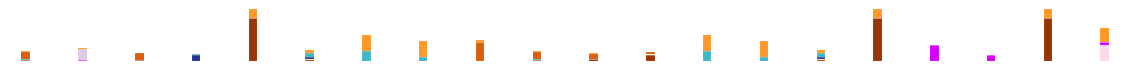

In [ ]:
ax = temp_df.plot.bar(stacked=True, 
                    figsize=(20,1), 
                    width=0.15,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='white', 
                    linewidth=0.1,
                    legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_xticklabels(short_names, rotation=90, ha='right', fontsize=12)
ax.set_xticklabels([])
#ax.legend(bbox_to_anchor=(1.08, 1), fontsize='medium', labelspacing=0.1, frameon=False)
#plt.title('Present motifs', fontsize=24)
plt.yticks([])
plt.axis('off')
plt.show()

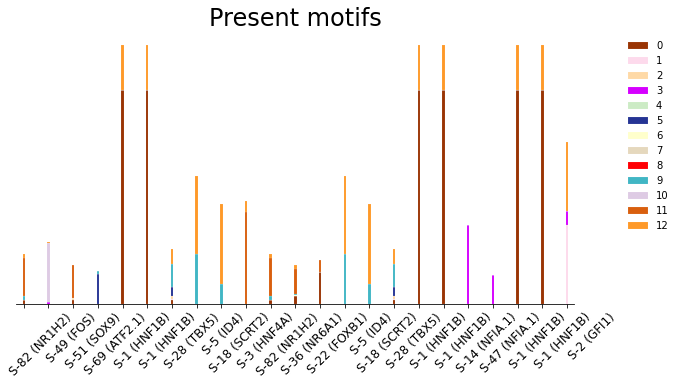

In [ ]:
import matplotlib.transforms as tr

fig, ax = plt.subplots(1, 1, figsize = (7, 3))

ax = temp_df.plot.bar(stacked=True, 
                    figsize=(10,5), 
                    width=0.1,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='white', 
                    linewidth=0.1, 
                    ax=ax)
for tick in ax.get_xticklabels():
    tick.set_transform(tick.get_transform()+tr.ScaledTranslation(0.7, 0, fig.dpi_scale_trans))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.08, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title('Present motifs', fontsize=24)
plt.yticks([])
plt.show()

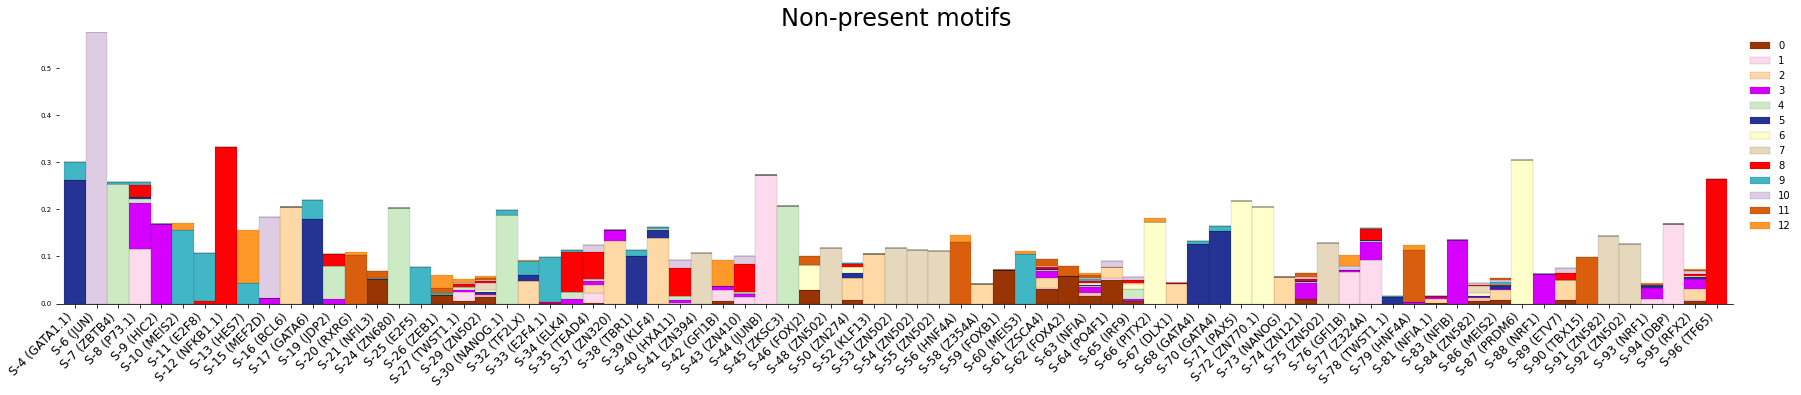

In [ ]:
temp_df_2 = merged_tf_df[~merged_tf_df['motif_id'].isin(motif_ids)]

ax = temp_df_2[program_columns].plot.bar(stacked=True, 
                    figsize=(30,5), 
                    width=1,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(temp_df_2['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title('Non-present motifs', fontsize=24)
plt.show()

In [ ]:
find_motif_names

['82-CAAAGGTCAA',
 '49-TGACTAA',
 '51-CAATGGGCCCATTGT',
 '69-TGATAACA',
 '1-RGTTAATSATTAACY',
 '1-RGTTAATSATTAACY',
 '28-AGGTGTGAAC',
 '5-ACACCTGTC',
 '18-ACAGGTG',
 '3-GGTYCAAAGTCCAHH',
 '82-CAAAGGTCAA',
 '36-GTTCAAGGTCA',
 '22-AATATTTRCHYARB',
 '5-ACACCTGTC',
 '18-ACAGGTG',
 '28-AGGTGTGAAC',
 '1-RGTTAATSATTAACY',
 '1-RGTTAATSATTAACY',
 '14-STTGGCATCNY',
 '47-ATGCCAA',
 '1-RGTTAATSATTAACY',
 '1-RGTTAATSATTAACY',
 '2-GCHGTGATTTAY']

In [ ]:
orientations

['+',
 '-',
 '-',
 '-',
 '+',
 '-',
 '-',
 '+',
 '-',
 '-',
 '-',
 '-',
 '+',
 '-',
 '+',
 '+',
 '-',
 '+',
 '+',
 '-',
 '+',
 '-',
 '+']

In [ ]:
boda2_df

ID  \
0        20211210_200256__612928__5::fsp_uc__hepg2__0   
1       20211210_200256__612928__12::fsp_uc__hepg2__0   
2       20211210_200256__612928__47::fsp_uc__hepg2__0   
3       20211210_200256__612928__69::fsp_uc__hepg2__0   
4       20211210_200256__612928__93::fsp_uc__hepg2__0   
...                                               ...   
120052                        ORF54316:2538:1300-1500   
120053                          ORF53130:1455:400-600   
120054                        ORF55877:2391:1900-2100   
120055                          ORF52950:2193:400-600   
120056                        ORF54639:2928:1800-2000   

                                                 sequence           project  \
0       CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...        BODA:hepg2   
1       GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...        BODA:hepg2   
2       GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...        BODA:hepg2   
3       TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...        BODA:hepg2   
4       AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...        BODA:hepg2   
...                                                   ...               ...   
120052  CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...  MPRA:ORF_negCtrl   
120053  GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...  MPRA:ORF_negCtrl   
120054  CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...  MPRA:ORF_negCtrl   
120055  AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...  MPRA:ORF_negCtrl   
120056  GACCTCCAGGCATACGAGGACCCTGCACAGGGAGCCTTGGACTTTA...  MPRA:ORF_negCtrl   

        method  round  K562_signal  HepG2_signal  SKNSH_signal  K562_lfcSE  \
0       fsp_uc      0     2.520816      5.287727      0.605723    0.316205   
1       fsp_uc      0     0.609272      6.402153      0.271218    0.285060   
2       fsp_uc      0     1.486130      4.276053     -0.578350    0.271874   
3       fsp_uc      0     2.440630      5.615395      1.063669    0.219559   
4       fsp_uc      0     3.765216      4.683140      0.171043    0.570148   
...        ...    ...          ...           ...           ...         ...   
120052     NaN      0    -0.315267      0.591628      0.068697    0.384919   
120053     NaN      0    -0.134821     -0.359782     -0.022281    0.178379   
120054     NaN      0     0.646673      0.489900      0.462366    0.259927   
120055     NaN      0    -0.061676     -0.014411      0.239693    0.171760   
120056     NaN      0     0.107924      0.306959     -0.092440    0.193708   

        HepG2_lfcSE  SKNSH_lfcSE  K562_ctrl_mean  HepG2_ctrl_mean  \
0          0.309186     0.208455      450.265971       450.265971   
1          0.301327     0.340279      186.544915       186.544915   
2          0.366801     0.241865      914.631030       914.631030   
3          0.313984     0.230603      141.922642       141.922642   
4          0.612207     2.165178        6.626839         6.626839   
...             ...          ...             ...              ...   
120052     0.363142     0.275408      240.760540       240.760540   
120053     0.261176     0.200300      870.259457       870.259457   
120054     0.190735     0.111966     1853.324459      1853.324459   
120055     0.199712     0.166026     1120.042556      1120.042556   
120056     0.209708     0.274950      547.677700       547.677700   

        SKNSH_ctrl_mean  K562_exp_mean  HepG2_exp_mean  SKNSH_exp_mean  \
0            450.265971    2584.983789    17588.102886      684.911429   
1            186.544915     285.193149    15770.229152      224.886662   
2            914.631030    2563.392133    17720.211245      612.217031   
3            141.922642     771.612103     6958.102060      296.614753   
4              6.626839      90.495400      169.731161        7.443428   
...                 ...            ...             ...             ...   
120052       240.760540     195.296914      362.833793      252.652472   
120053       870.259457     793.895718      678.145587     

  0%|          | 0/91 [00:00<?, ?it/s]

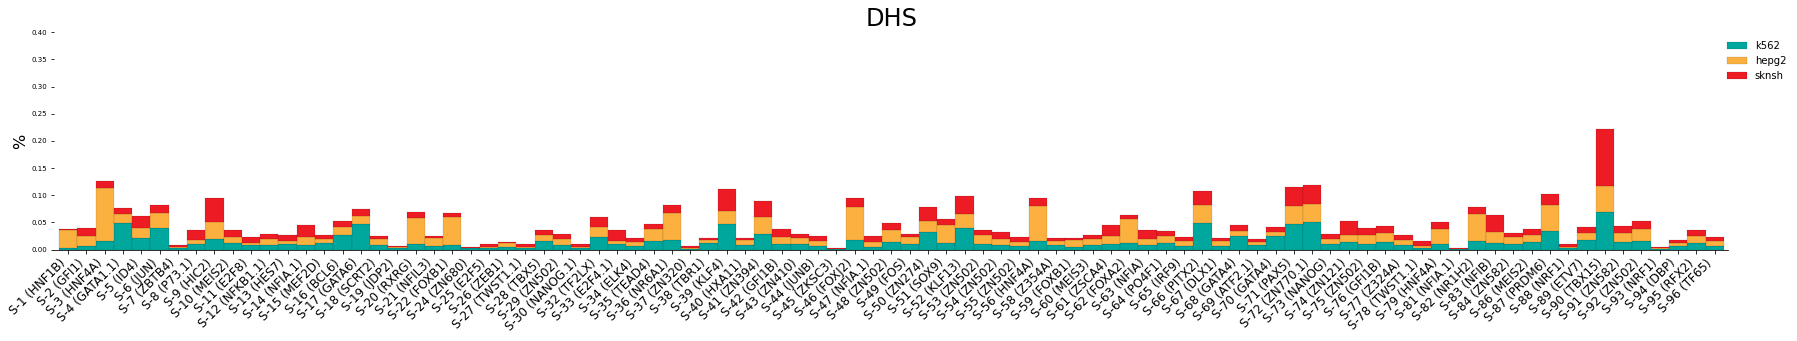

In [ ]:
method = 'DHS'
counts = []
for motif_ID in tqdm(merged_tf_df['motif_id'].tolist()):
    seq_list = fimo_df[fimo_df['motif_id'] == motif_ID]['sequence_name'].unique().tolist()
    row_filter = boda2_df['ID'].isin(seq_list) & (boda2_df['method'] == method)
    counts.append(boda2_df[row_filter]['target_cell'].value_counts(dropna=False))

count_df = pd.concat(counts, axis=1).T / (boda2_df['method'] == method).sum()
count_df['Target_ID_short'] = merged_tf_df['Target_ID_short'].tolist()
count_df = count_df.reset_index(drop=True)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_pal = sns.color_palette(cell_colors)

ax = count_df[['k562', 'hepg2', 'sknsh']].plot.bar(stacked=True, 
                    figsize=(30,4), 
                    width=1,
                    color=cell_pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(count_df['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title(f'{method}', fontsize=24)
plt.ylim(0, 0.4)
plt.ylabel('%', fontsize=16)
plt.show()

  0%|          | 0/91 [00:00<?, ?it/s]

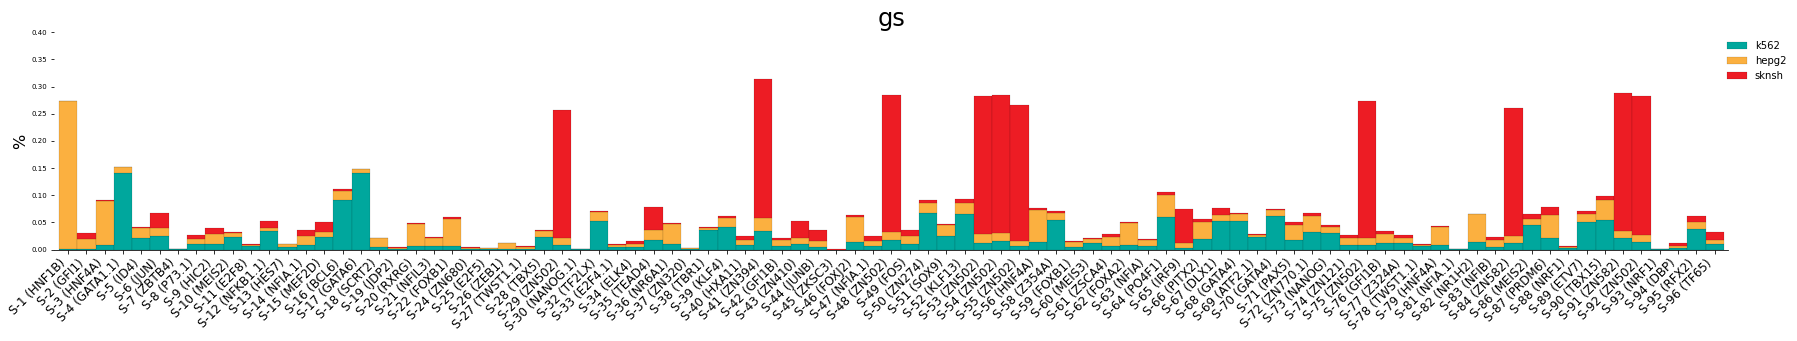

In [ ]:
method = 'gs'
counts = []
for motif_ID in tqdm(merged_tf_df['motif_id'].tolist()):
    seq_list = fimo_df[fimo_df['motif_id'] == motif_ID]['sequence_name'].unique().tolist()
    row_filter = boda2_df['ID'].isin(seq_list) & (boda2_df['method'] == method)
    counts.append(boda2_df[row_filter]['target_cell'].value_counts(dropna=False))

count_df = pd.concat(counts, axis=1).T / (boda2_df['method'] == method).sum()
count_df['Target_ID_short'] = merged_tf_df['Target_ID_short'].tolist()
count_df = count_df.reset_index(drop=True)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_pal = sns.color_palette(cell_colors)

ax = count_df[['k562', 'hepg2', 'sknsh']].plot.bar(stacked=True, 
                    figsize=(30,4), 
                    width=1,
                    color=cell_pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(count_df['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title(f'{method}', fontsize=24)
plt.ylim(0, 0.4)
plt.ylabel('%', fontsize=16)
plt.show()

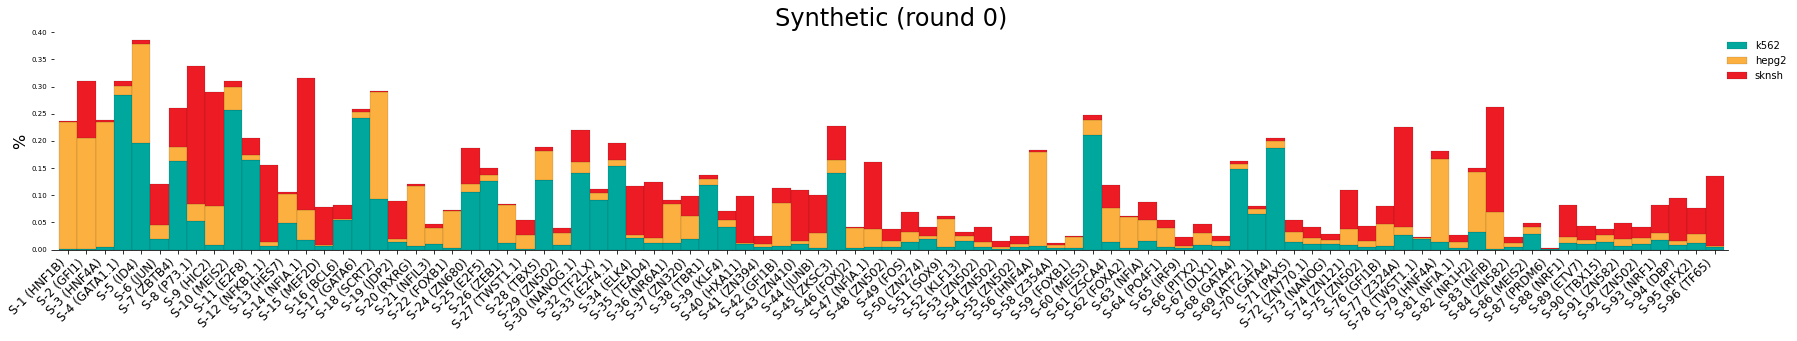

In [ ]:
methods = ['fsp', 'sa', 'al']
counts = []
for motif_ID in tqdm(merged_tf_df['motif_id'].tolist()):
    seq_list = fimo_df[fimo_df['motif_id'] == motif_ID]['sequence_name'].unique().tolist()
    row_filter = boda2_df['ID'].isin(seq_list) & (boda2_df['method'].isin(methods)) & (boda2_df['round'] == 0)
    counts.append(boda2_df[row_filter]['target_cell'].value_counts(dropna=False))

count_df = pd.concat(counts, axis=1).T / ((boda2_df['method'].isin(methods)) & (boda2_df['round'] == 0)).sum()
count_df['Target_ID_short'] = merged_tf_df['Target_ID_short'].tolist()
count_df = count_df.reset_index(drop=True)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_pal = sns.color_palette(cell_colors)

ax = count_df[['k562', 'hepg2', 'sknsh']].plot.bar(stacked=True, 
                    figsize=(30,4), 
                    width=1,
                    color=cell_pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(count_df['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title(f'Synthetic (round 0)', fontsize=24)
plt.ylim(0, 0.4)
plt.ylabel('%', fontsize=16)
plt.show()

  0%|          | 0/91 [00:00<?, ?it/s]

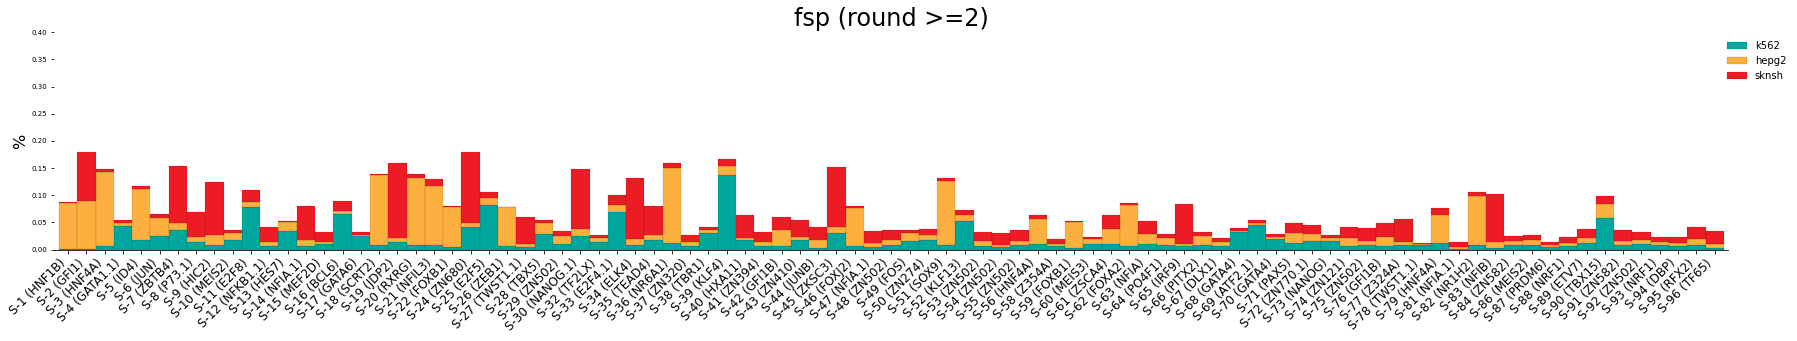

In [ ]:
method = 'fsp'
counts = []
for motif_ID in tqdm(merged_tf_df['motif_id'].tolist()):
    seq_list = fimo_df[fimo_df['motif_id'] == motif_ID]['sequence_name'].unique().tolist()
    counts.append(boda2_df[boda2_df['ID'].isin(seq_list) & \
                           (boda2_df['method'] == method) & \
                           (boda2_df['round'] > 1)]['target_cell'].value_counts(dropna=False))

count_df = pd.concat(counts, axis=1).T / ((boda2_df['method'] == method) & (boda2_df['round'] > 1)).sum()
count_df['Target_ID_short'] = merged_tf_df['Target_ID_short'].tolist()
count_df = count_df.reset_index(drop=True)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_pal = sns.color_palette(cell_colors)

ax = count_df[['k562', 'hepg2', 'sknsh']].plot.bar(stacked=True, 
                    figsize=(30,4), 
                    width=1,
                    color=cell_pal, 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(count_df['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
plt.title(f'{method} (round >=2)', fontsize=24)
plt.ylim(0, 0.4)
plt.ylabel('%', fontsize=16)
plt.show()

In [ ]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
temp_df = boda2_df[(boda2_df['round'] == 0) & (boda2_df['method'].isin(methods))]
counts = []
for motif_ID in tqdm(merged_tf_df['motif_id'].tolist()):
    seq_list = fimo_df[fimo_df['motif_id'] == motif_ID]['sequence_name'].unique().tolist()
    counts.append(temp_df[temp_df['ID'].isin(seq_list)]['method'].value_counts())

count_df = pd.concat(counts, axis=1).T 
count_df['Target_ID_short'] = merged_tf_df['Target_ID_short'].tolist()
count_df = count_df.reset_index(drop=True)

  0%|          | 0/91 [00:00<?, ?it/s]

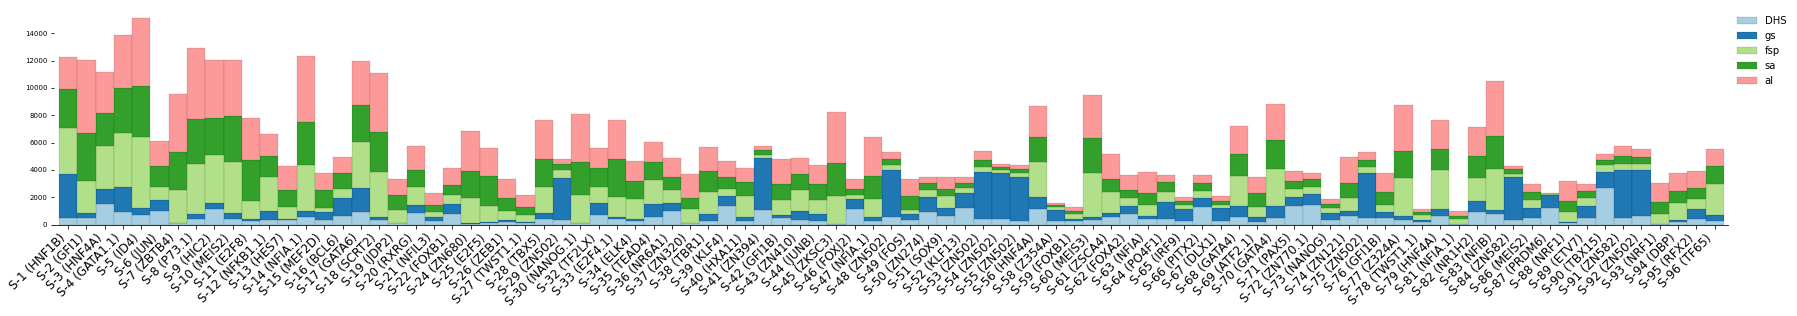

In [ ]:
ax = count_df[methods].plot.bar(stacked=True, 
                    figsize=(30,4), 
                    width=1,
                    color=sns.color_palette("Paired"), 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(count_df['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
# plt.title(f'{method} (round >=2)', fontsize=24)
# plt.ylim(0, 0.4)
# plt.ylabel('%', fontsize=16)
plt.show()

In [ ]:
# methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
# temp_df = boda2_df[(boda2_df['round'] == 0) & (boda2_df['method'].isin(methods))]
# counts = []
# for motif_ID in tqdm(merged_tf_df['motif_id'].tolist()):
#     seq_list = fimo_df[fimo_df['motif_id'] == motif_ID]['sequence_name'].unique().tolist()
#     counts.append(temp_df[temp_df['ID'].isin(seq_list)]['OverMax'].mean())

mean_df = pd.DataFrame(counts, columns=['OverMax'], index=merged_tf_df['Target_ID_short'].tolist())
# mean_df['Target_ID_short'] = merged_tf_df['Target_ID_short'].tolist()
# mean_df = mean_df.reset_index(drop=True)

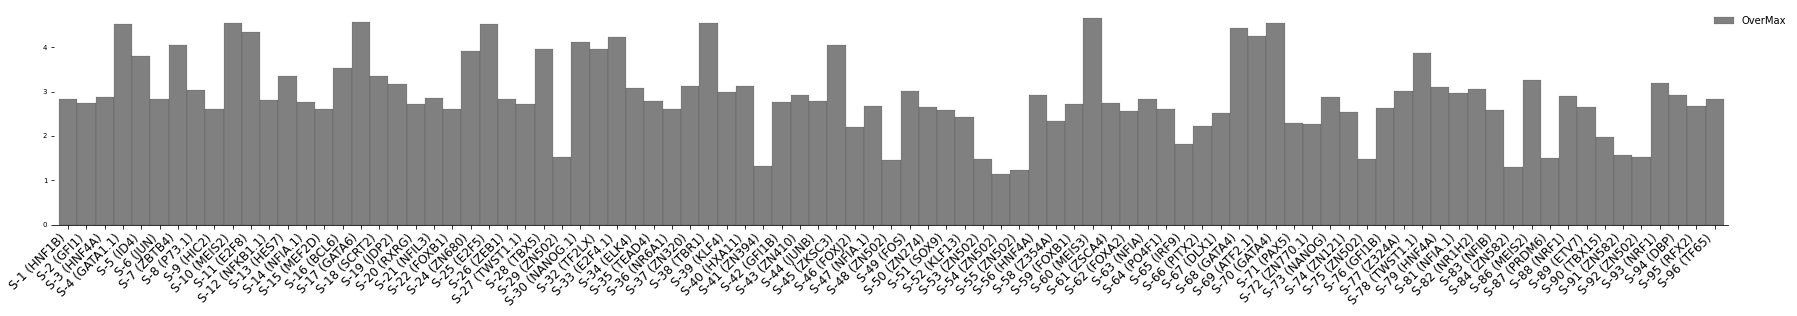

In [ ]:
ax = count_df['OverMax'].plot.bar(stacked=True, 
                    figsize=(30,4), 
                    width=1,
                    color='grey', 
                    fontsize='x-small',
                    edgecolor='black', 
                    linewidth=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(count_df['Target_ID_short'].tolist(), rotation=45, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1.04, 1), fontsize='medium', labelspacing=0.5, frameon=False)
# plt.title(f'{method} (round >=2)', fontsize=24)
# plt.ylim(0, 0.4)
# plt.ylabel('%', fontsize=16)
plt.show()

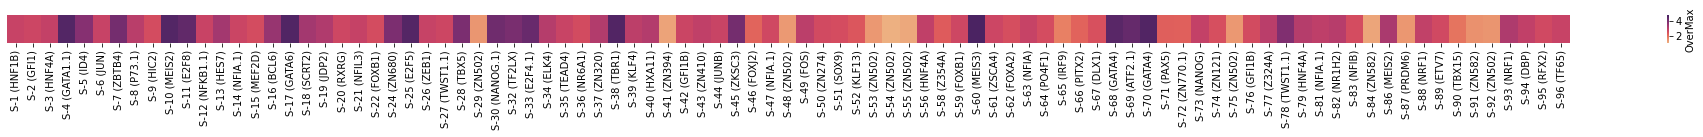

In [ ]:
plt.figure(figsize=(35,0.5)) 
sns.heatmap(mean_df.T, yticklabels=False, cmap='flare', cbar_kws={'label': 'OverMax'})
#plt.axis('off')
plt.show()

### Look for sequences with good matches between contributions and FIMO hits

In [ ]:
methods = ['fsp', 'gs', 'DHS']
merged_seq_df['method'].isin(methods).sum()

50889

20211212_12620__229779__1413::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68311    -0.440428      5.981998     -1.275506


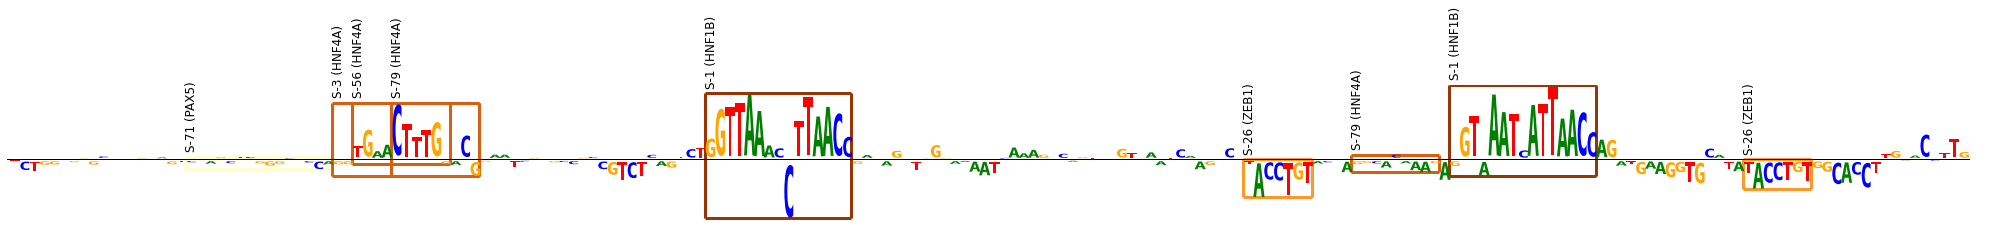



20211212_52639__969454__82::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70730    -0.656348       5.85801      -0.56365


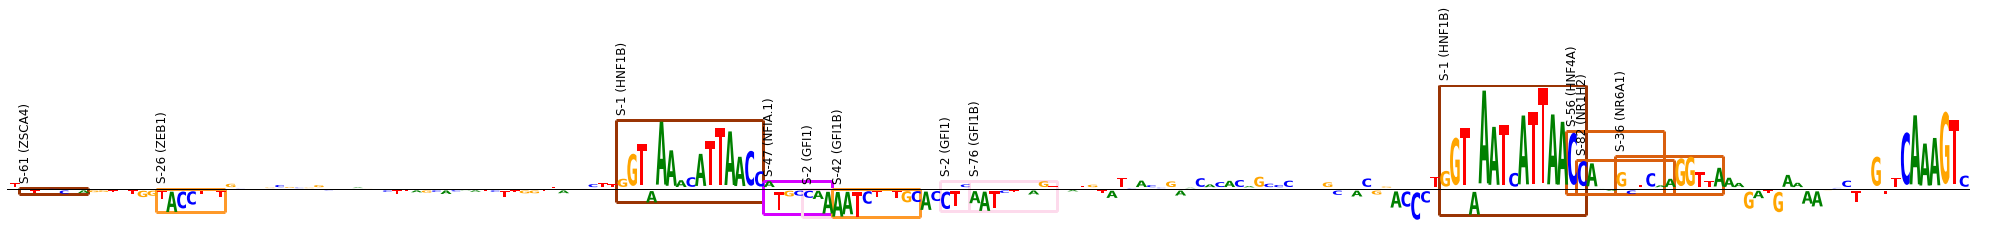



20211212_45907__313665__11::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68909    -0.959567      5.446063     -1.026001


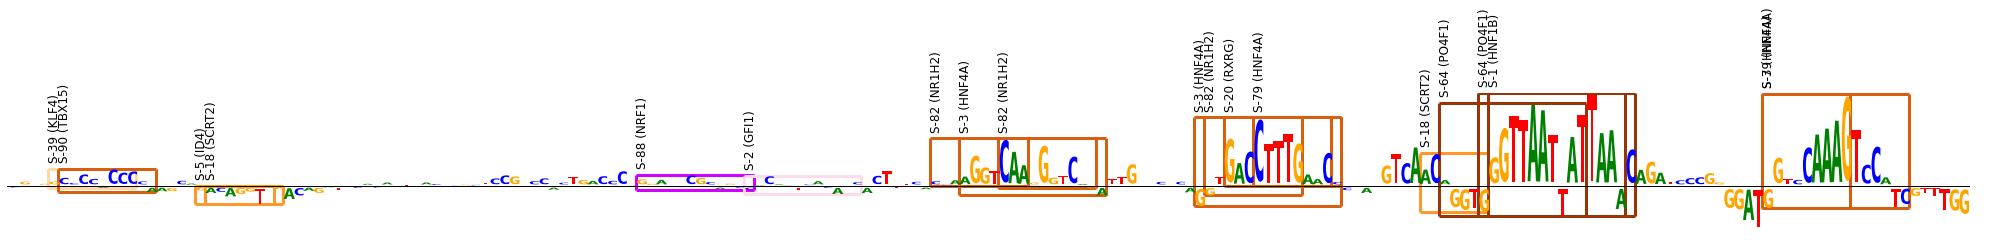



20211212_52639__969454__532::fsp__hepg2__1


       K562_signal  HepG2_signal  SKNSH_signal
71180    -0.250666      6.150915     -1.151957


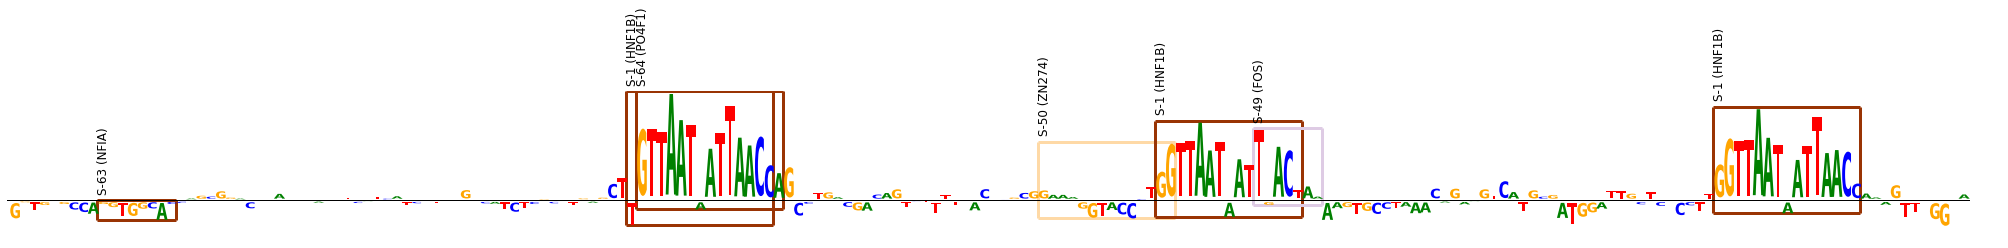



20211212_61436__944763__286::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
74434    -0.583286      5.789651     -1.180741


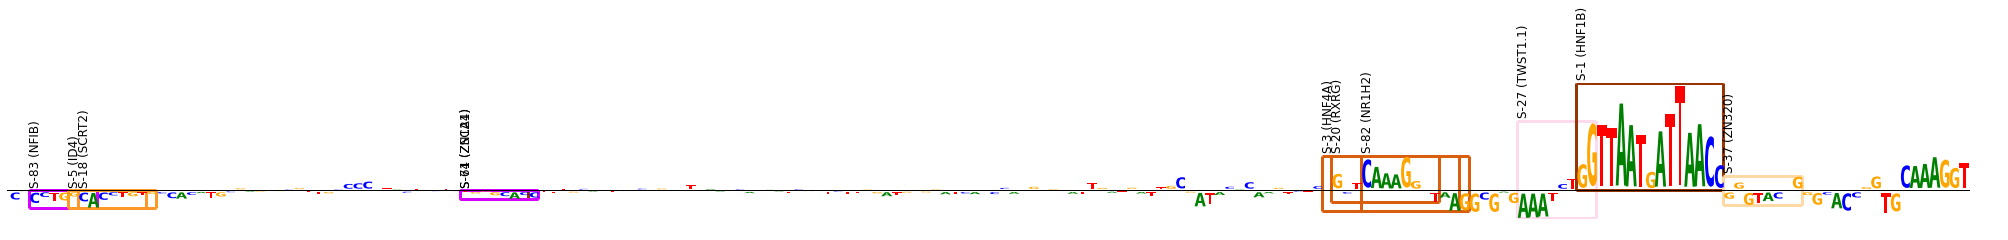



20211212_52639__969454__171::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70819    -1.503001      4.844852     -1.932425


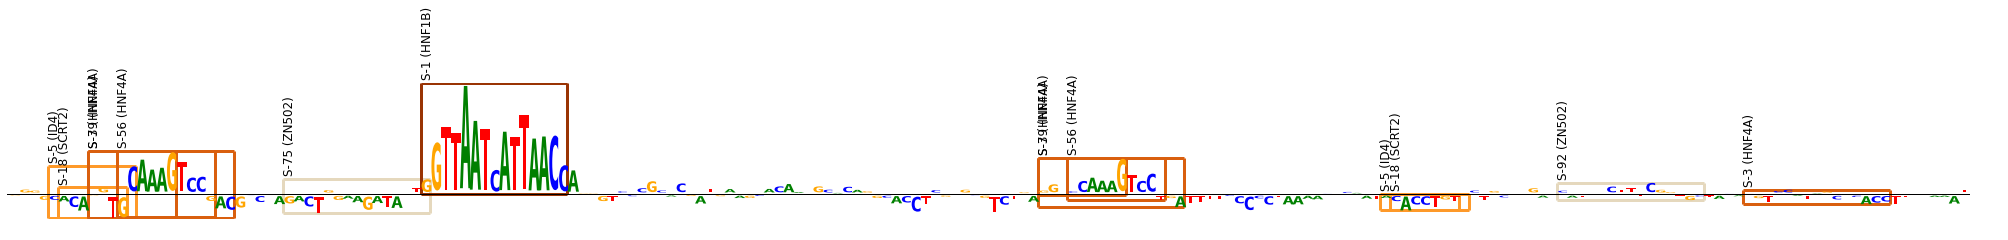



20211212_55149__346635__486::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
72884    -0.885311      5.454028     -1.582769


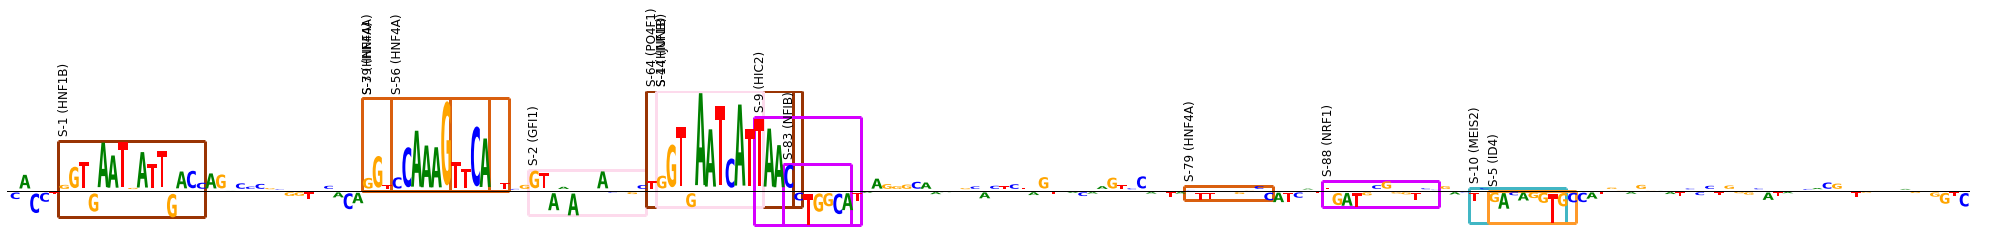



20211212_12620__229779__1420::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68318    -0.478482       5.85118     -0.860031


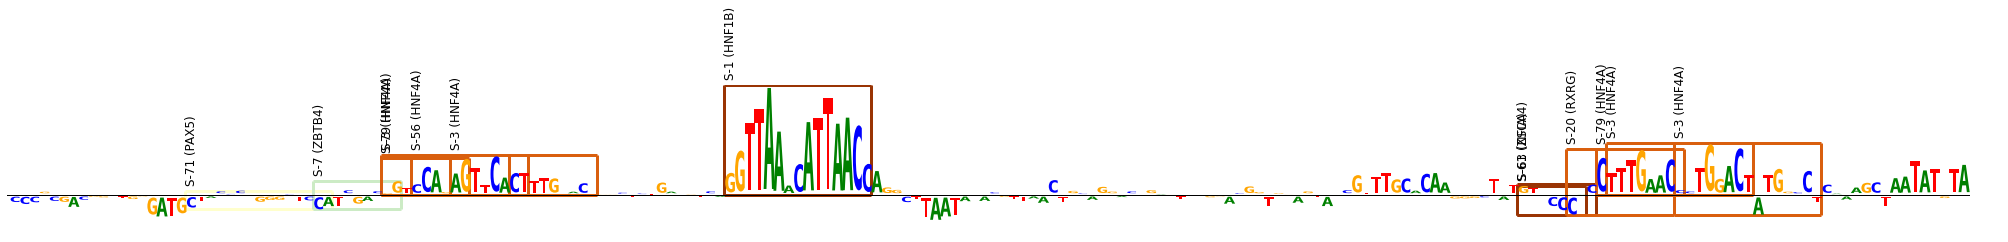



20211212_52639__969454__62::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70710     -1.17811      5.150547      -1.47238


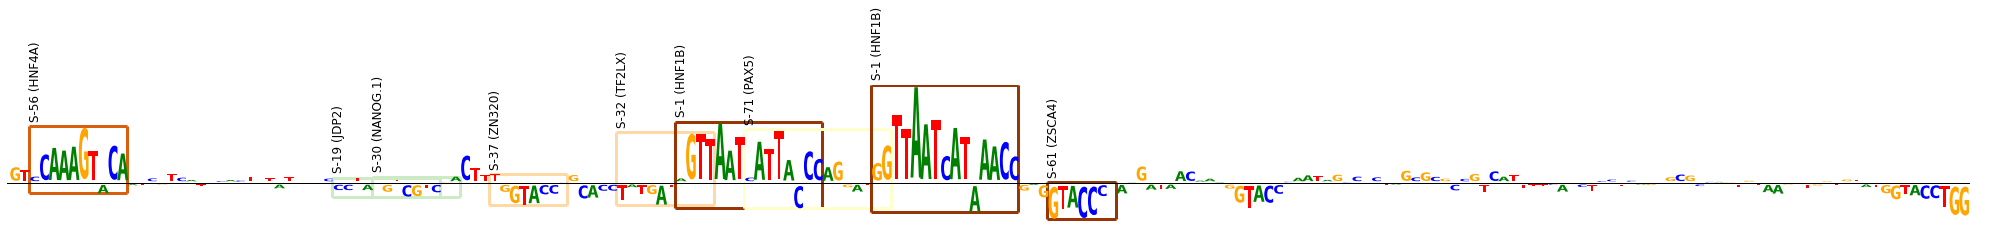



20211212_55149__346635__824::fsp__hepg2__2


       K562_signal  HepG2_signal  SKNSH_signal
73222     -1.39038      5.306879     -1.019328


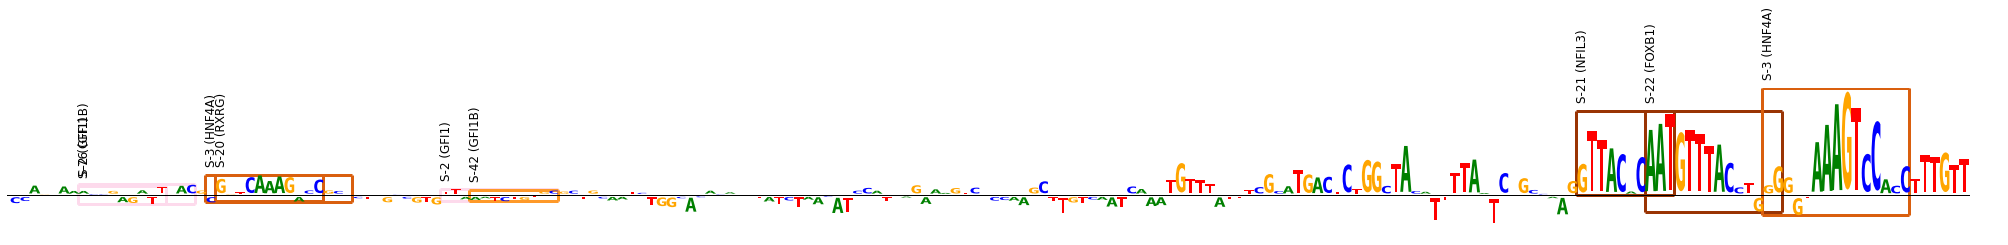



20211212_55149__346635__150::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
72548    -0.887287      5.426756     -0.920821


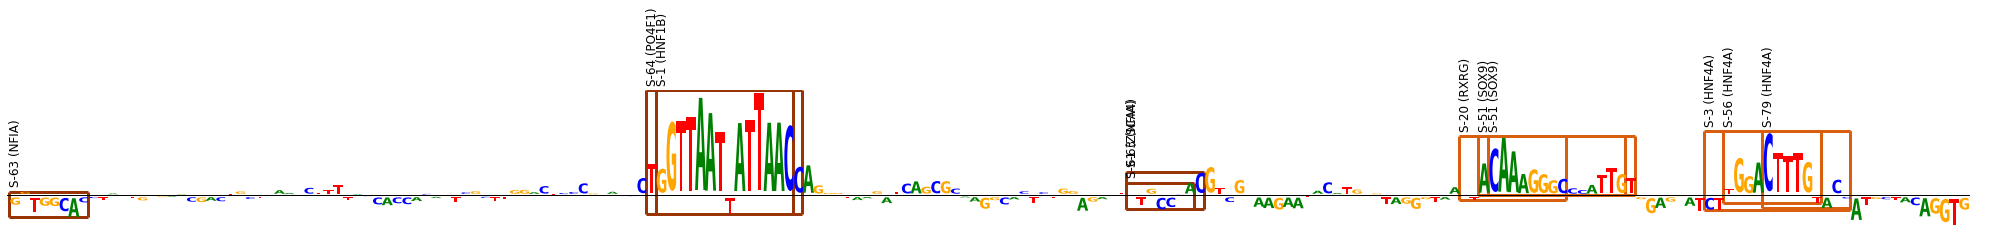



20211212_52639__969454__185::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70833    -0.787379      5.526433     -2.181965


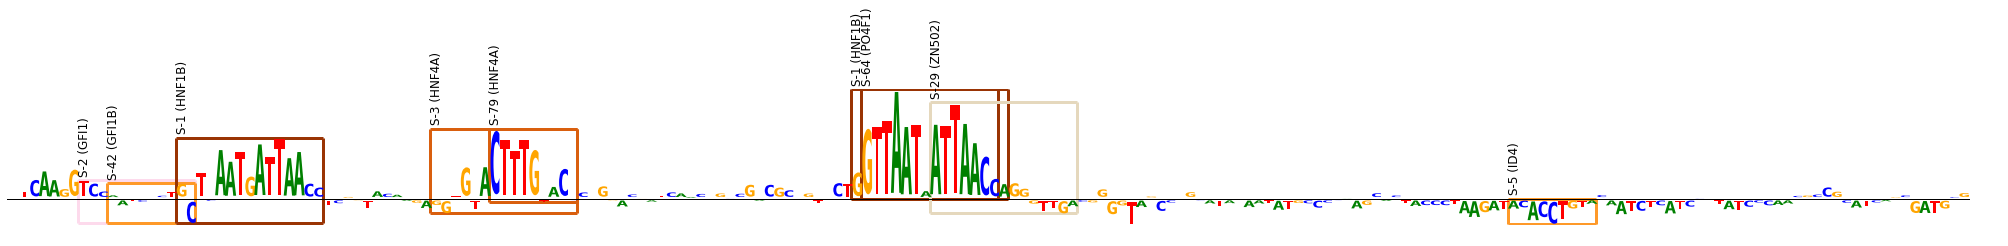



20211212_12620__229779__1181::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68079    -0.913115      5.545391     -0.767255


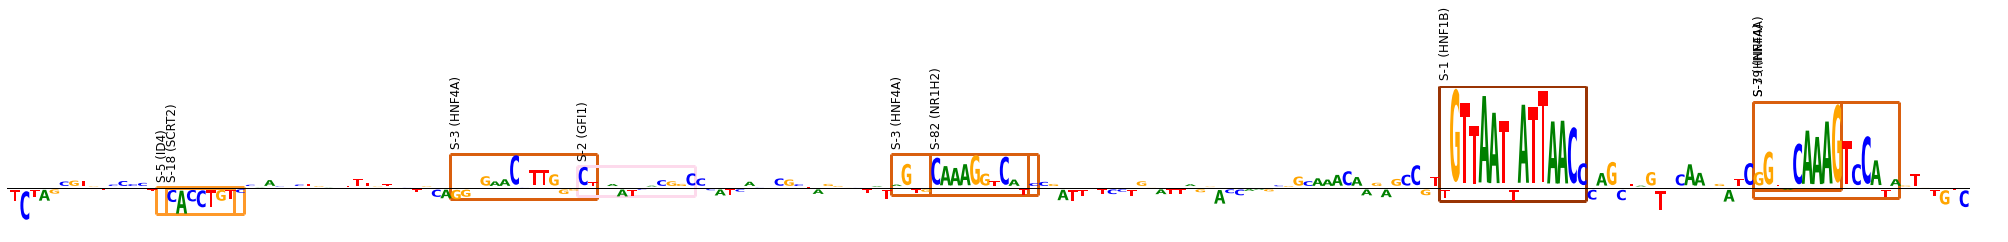



20211212_61436__944763__250::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
74398    -0.533844      5.773263     -0.762957


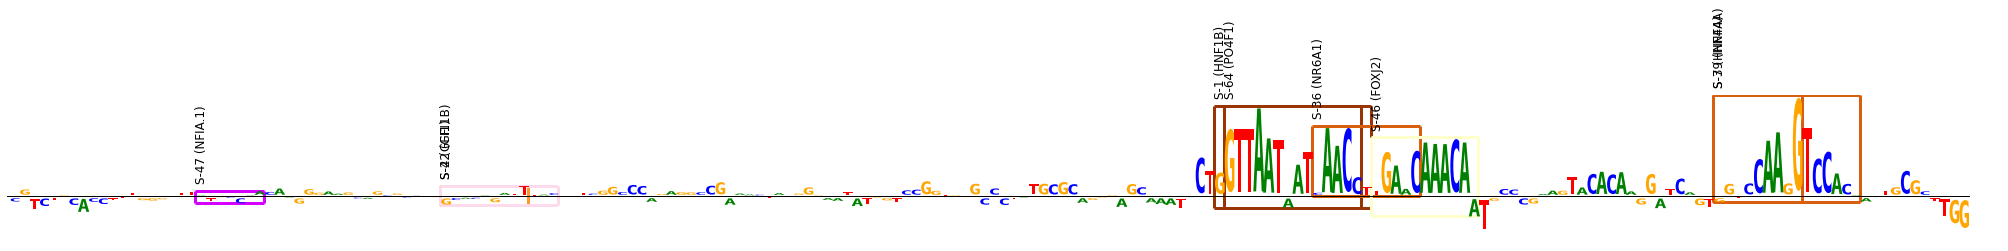



20211212_12620__229779__545::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
67443    -0.686615       5.61734     -1.215838


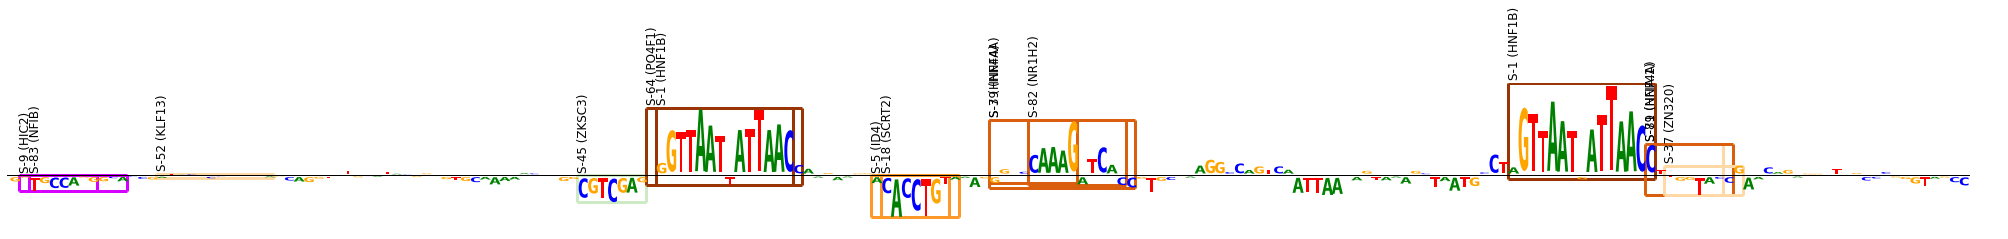



20211212_45907__313665__164::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
69062    -0.775599      5.527622     -1.792395


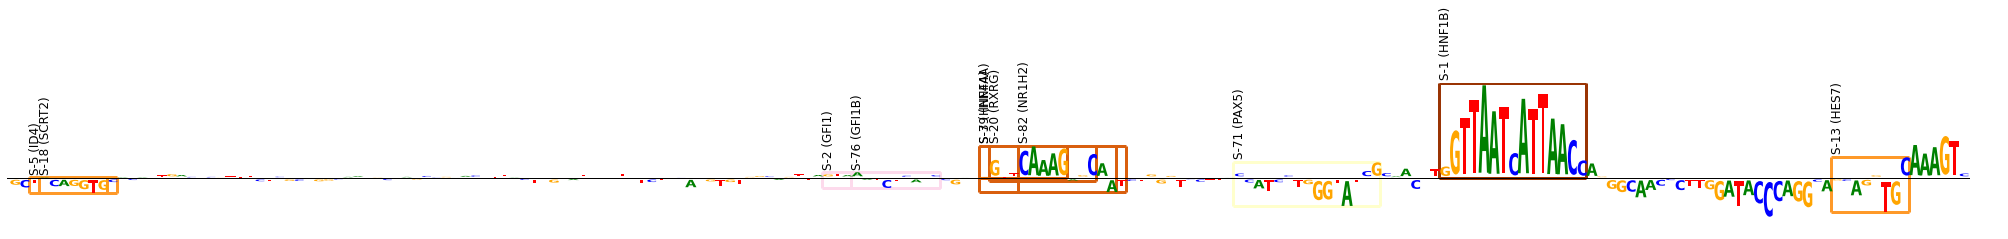



20211212_12620__229779__56::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
66954    -0.438644      5.859807     -0.732171


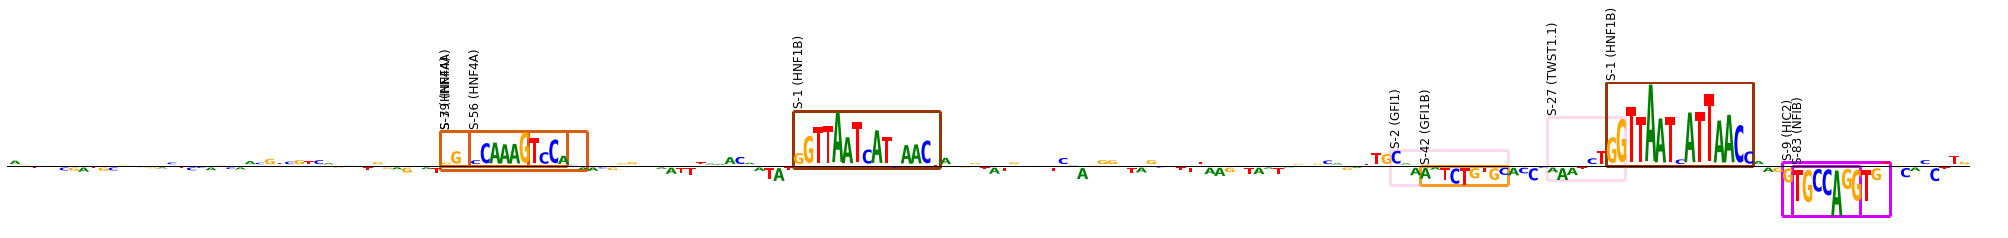



20211212_12620__229779__307::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
67205    -0.615831      5.766887     -0.504946


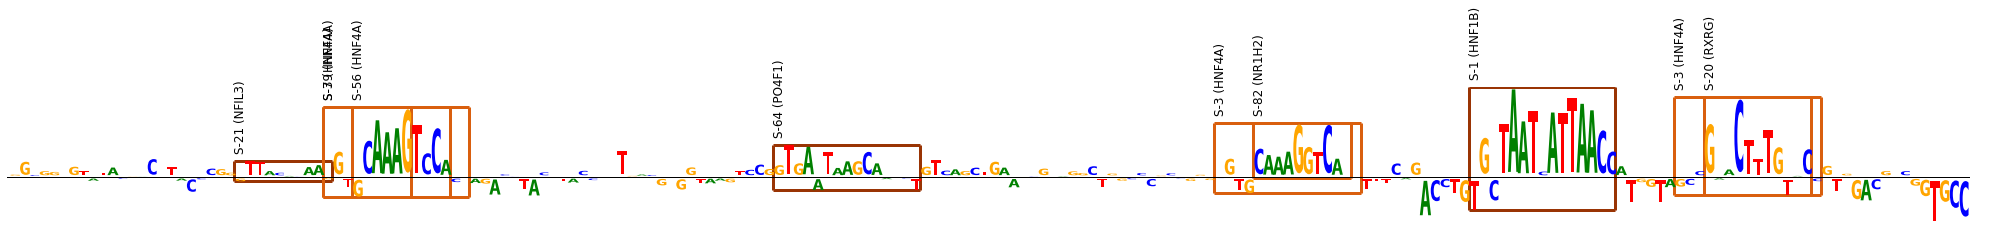



20211212_45907__313665__374::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
69272    -0.684857      5.560385     -1.146704


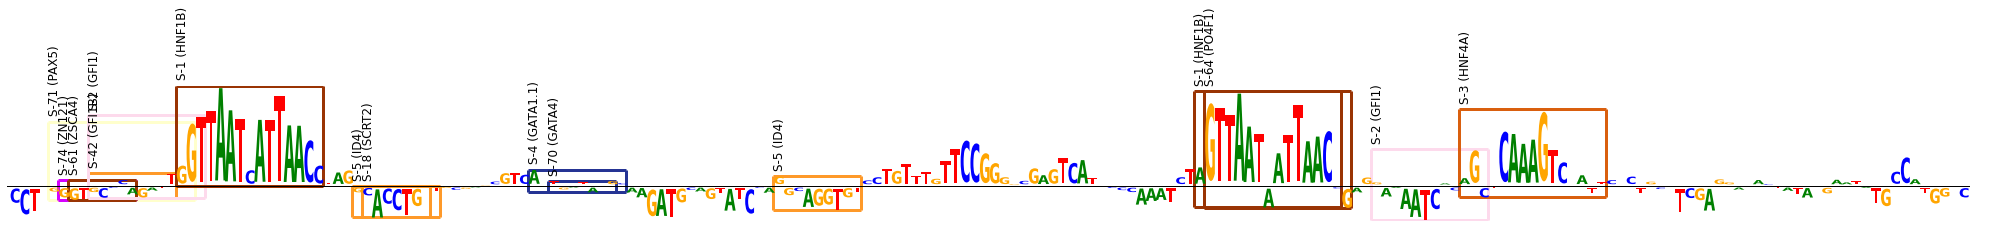



20211212_12620__229779__794::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
67692    -0.278808      5.952979     -1.001646


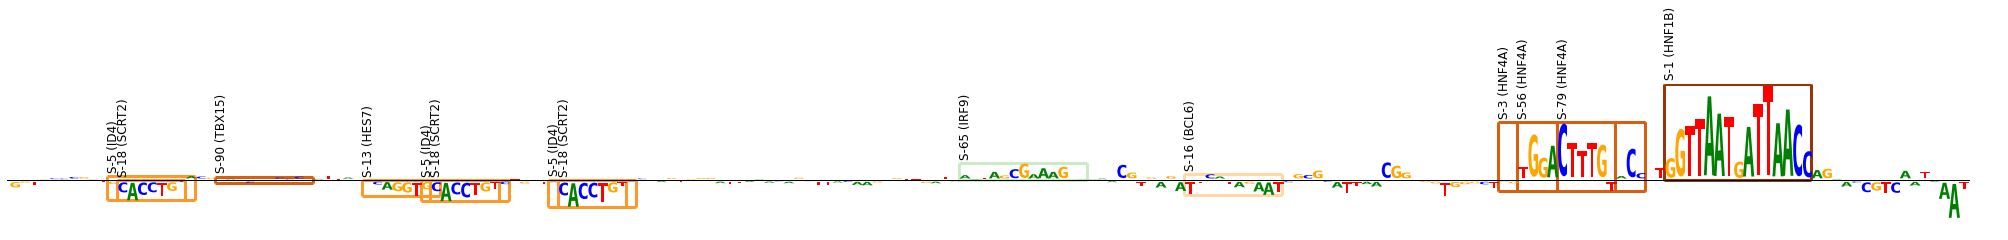

In [ ]:
methods = ['fsp', 'gs', 'DHS']
quality_filter = (merged_seq_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 

candidate_IDs = merged_seq_df[(merged_seq_df['target_cell'] == 'hepg2') & merged_seq_df['method'].isin(methods) & quality_filter]
candidate_IDs = candidate_IDs.sort_values('OverMax', ascending=False)['ID'][20:40].tolist()

for single_seq_id in candidate_IDs:
    print(single_seq_id)
    #--- Get sequence and contributions
    single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]
    test_str = single_seq_df['sequence'].item()
    test_onehot = utils.dna2tensor(test_str).view(4,-1)
    contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

    #--- Plot topic assignments
    ax = single_seq_df[program_columns].plot.barh(stacked=True, width=10, figsize=(5,0.25),
                            color=pal, linewidth=0.0, legend=False)
    plt.axis('off')
    plt.show()

    #--- Get FIMO hits
    seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
    seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
    print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])

    seq_contributions = contribution_tensor
    y_max = seq_contributions.max()

    color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
    motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    passing_idxs = []
    all_motif_contributions = []
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

        find_motif_names.append(hit_row['motif_id'])
        motifs_start_ends.append((m_start, m_end))
        orientations.append(hit_row['strand'])
        cover_set = cover_set | motif_range
        passing_idxs.append(i)
        all_motif_contributions.append(motif_contributions)


    #--- Plot contributions and FIMO hits
    #for i in range(0,3):
    i = 1
    matrix_plot = seq_contributions[i, ...]
    contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                        for m_start, m_end in motifs_start_ends]
    # fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
    #                     heightscale=0.8, fontaspect=0.55)
    fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                        fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
    for idx, motif_name in enumerate(find_motif_names):
        color = color_dict[motif_name]
        plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

        text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
        x = motifs_start_ends[idx][0] 
        y = contrib_min_maxs[idx][1] + 0.05  
        plt.text(x, y, text, fontsize=12, rotation=90)  
    plt.axis('off')
    plt.show()  

    print('')
    print('')

20211212_55149__346635__38::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
72436    -0.618553      6.099193     -0.870771


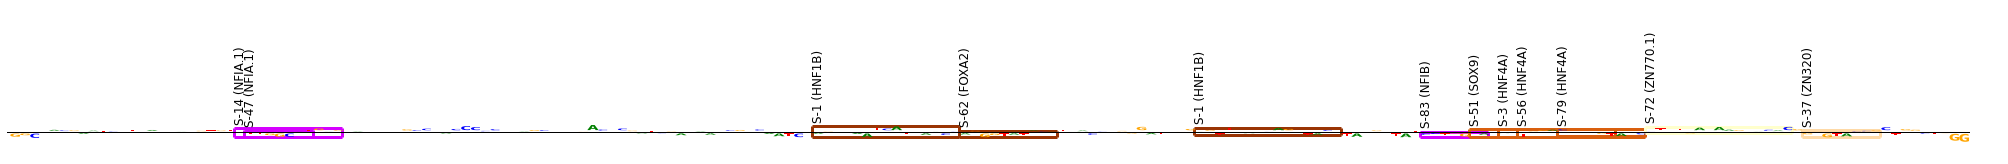

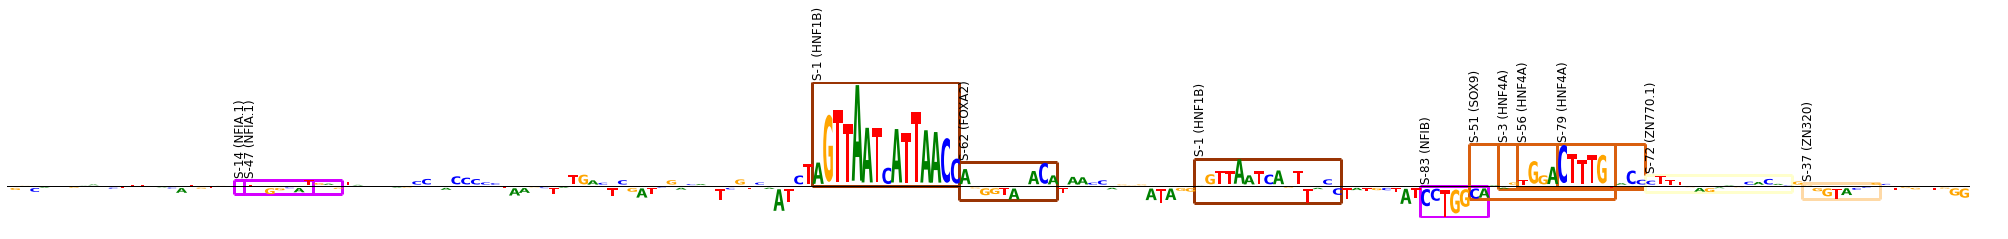

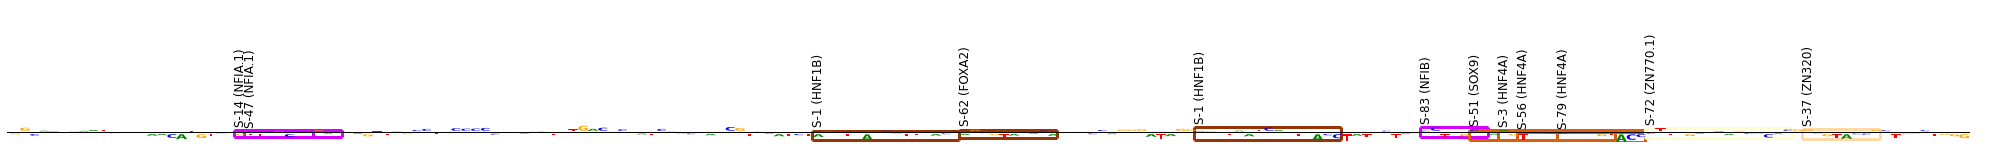



20211212_52639__969454__182::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70830    -0.705256      5.930304      -1.21233


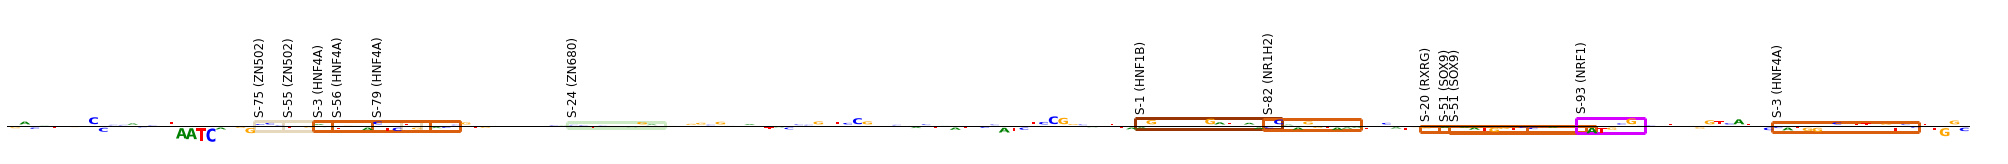

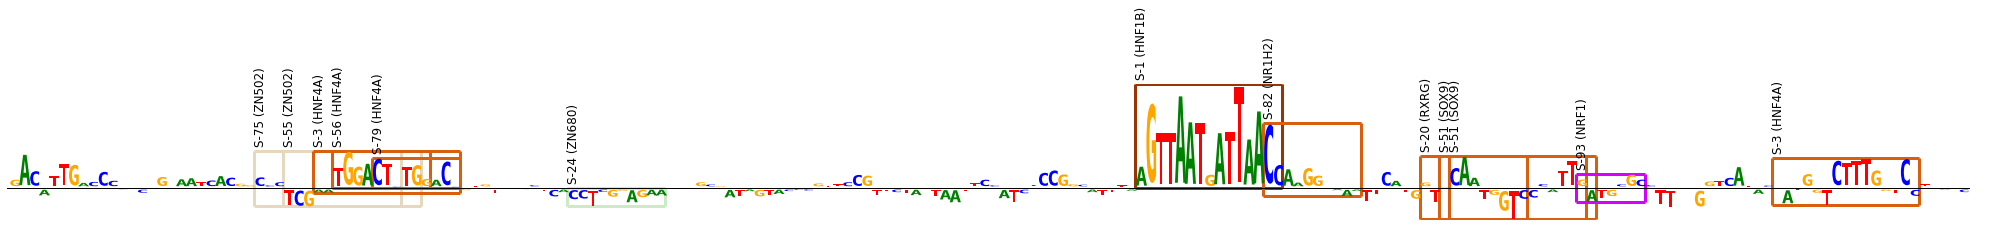

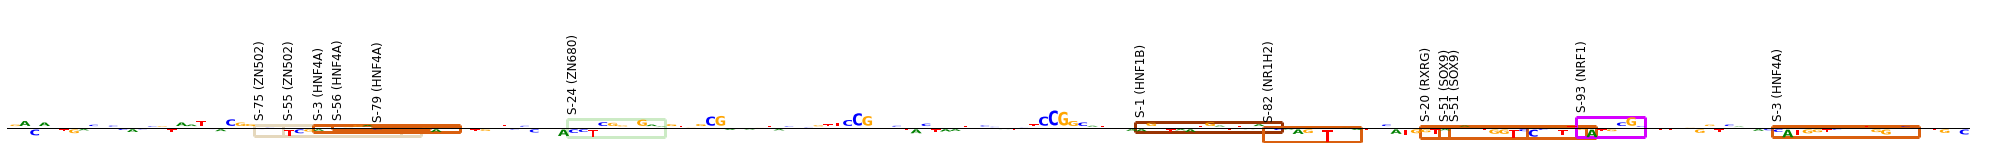



20211212_12620__229779__1223::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68121    -0.426471        6.0799     -0.835748


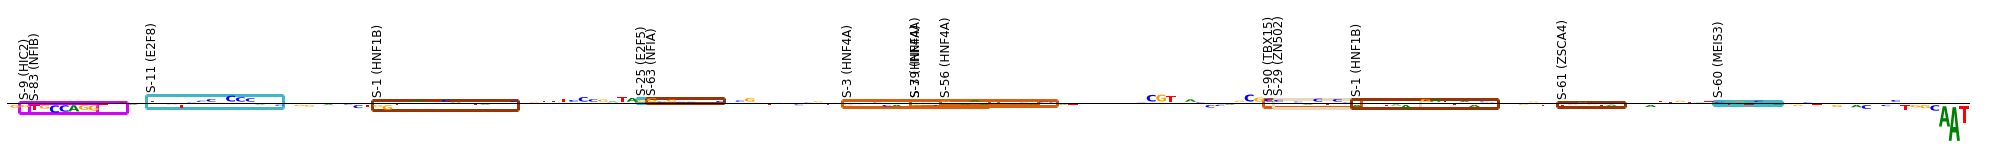

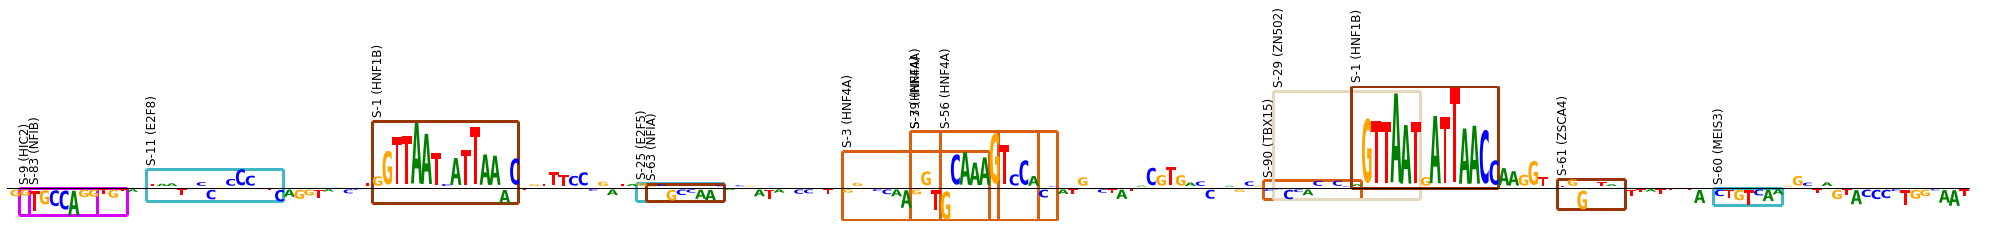

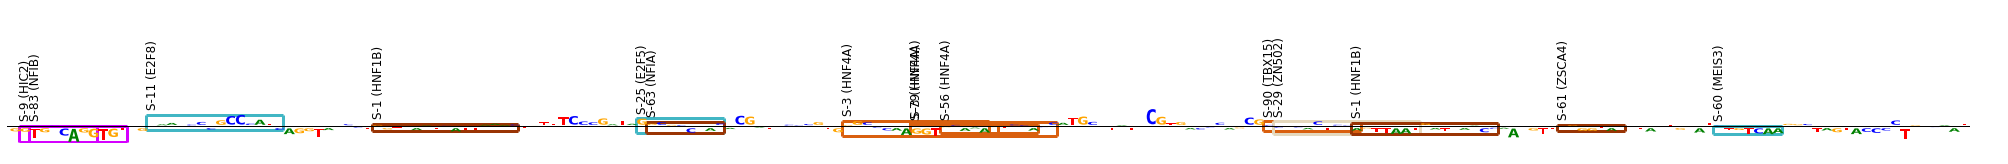



20211212_55149__346635__486::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
72884    -0.885311      5.454028     -1.582769


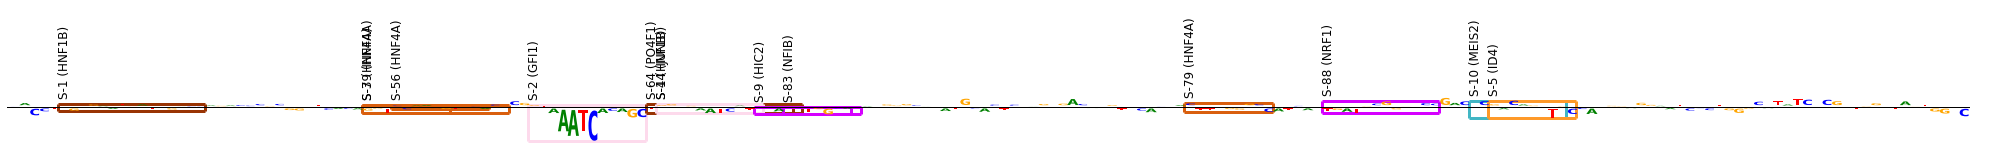

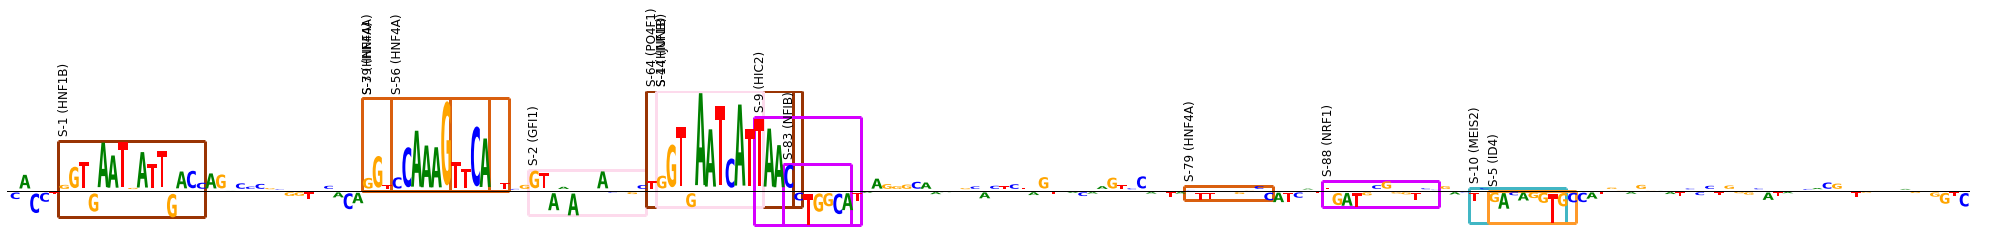

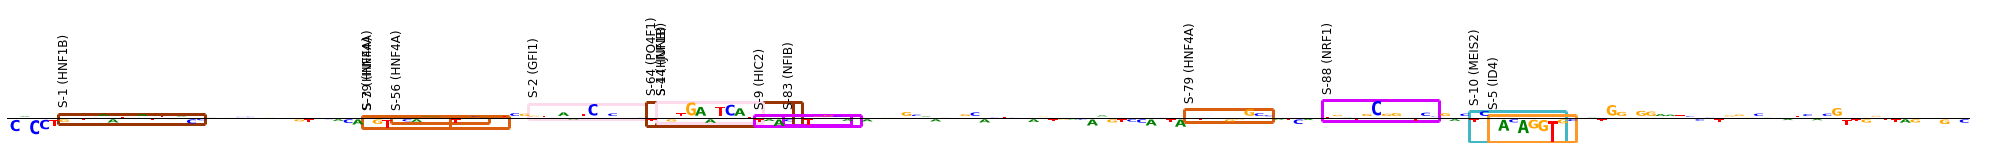



20211212_55149__346635__150::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
72548    -0.887287      5.426756     -0.920821


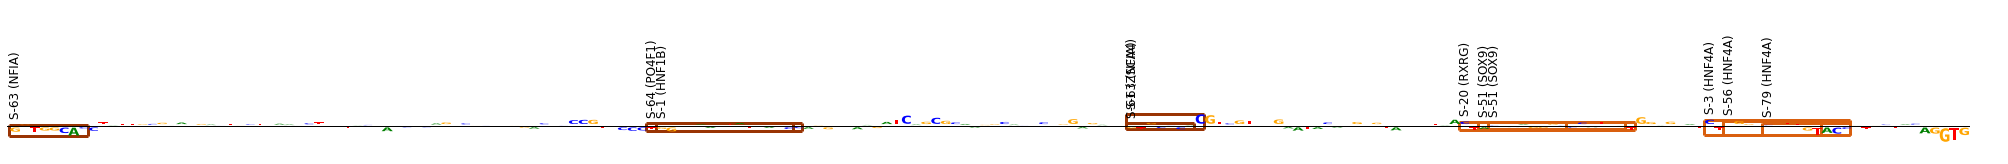

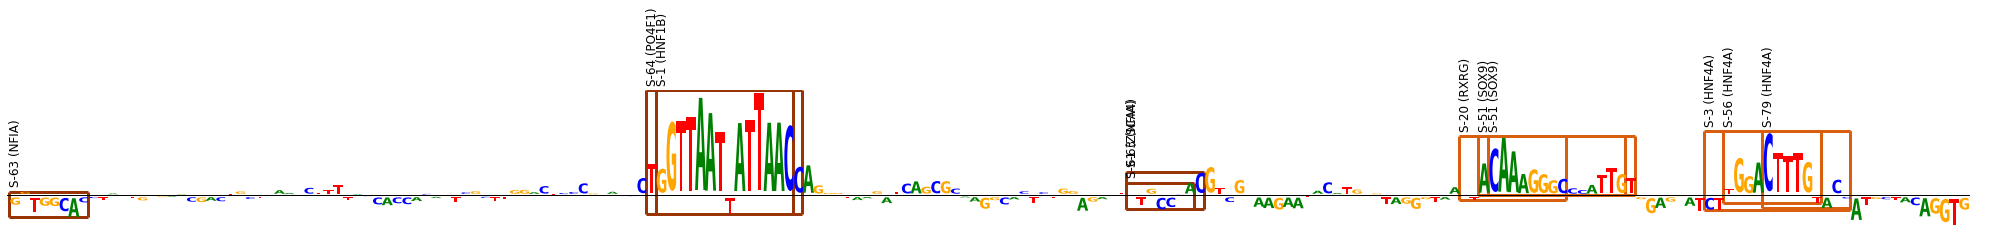

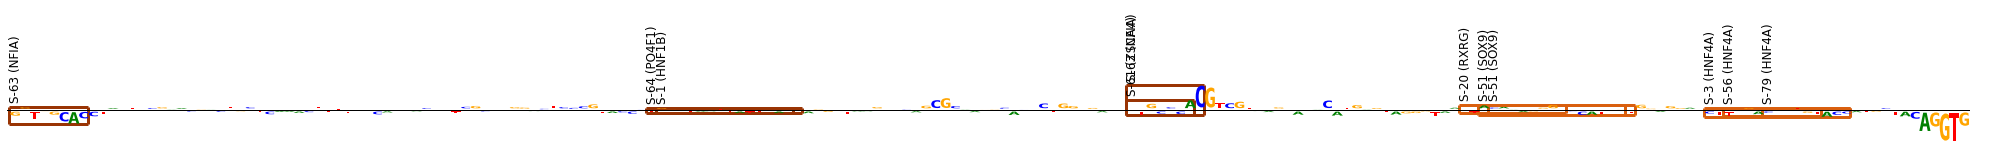



20211212_52639__969454__185::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70833    -0.787379      5.526433     -2.181965


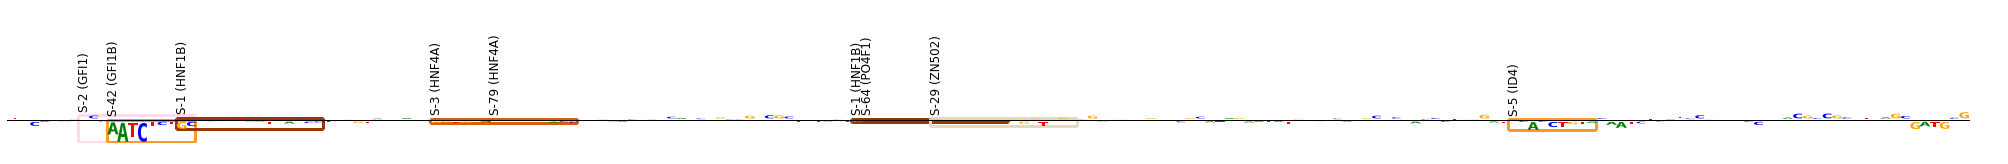

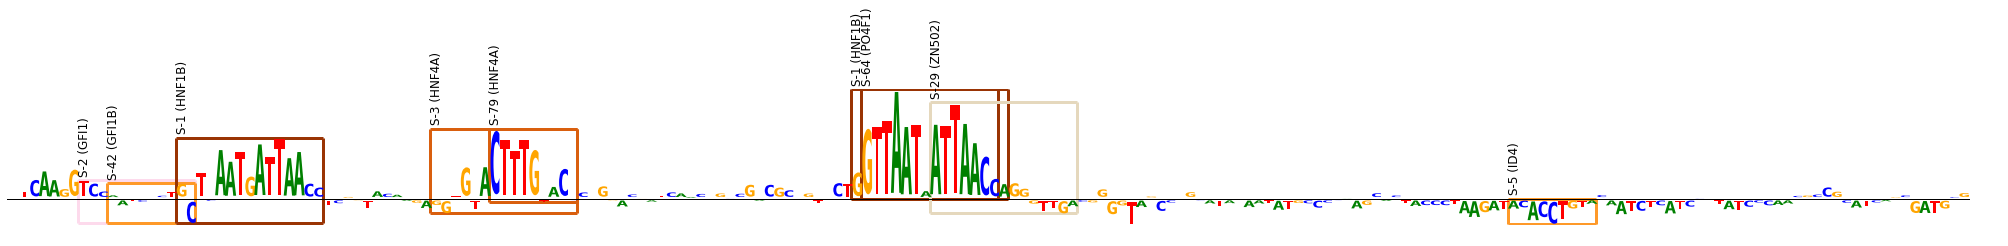

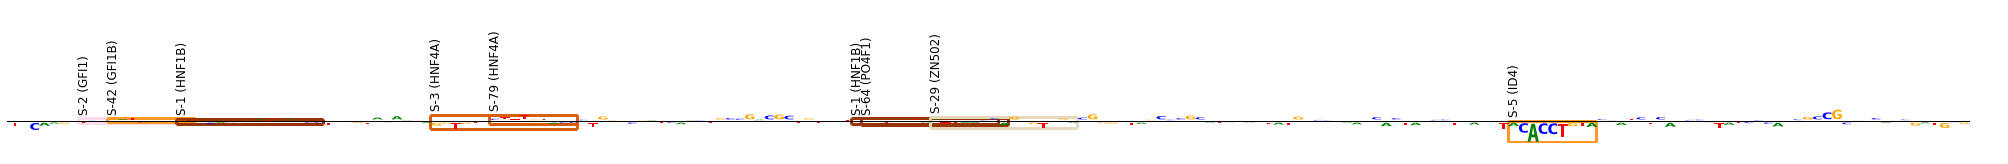



20211212_12620__229779__1181::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68079    -0.913115      5.545391     -0.767255


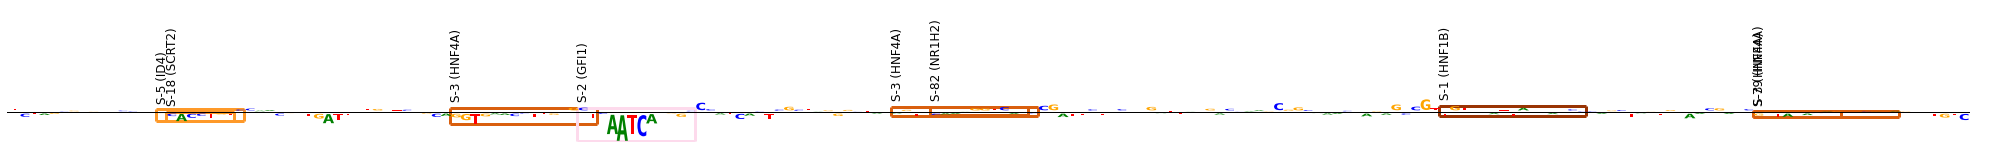

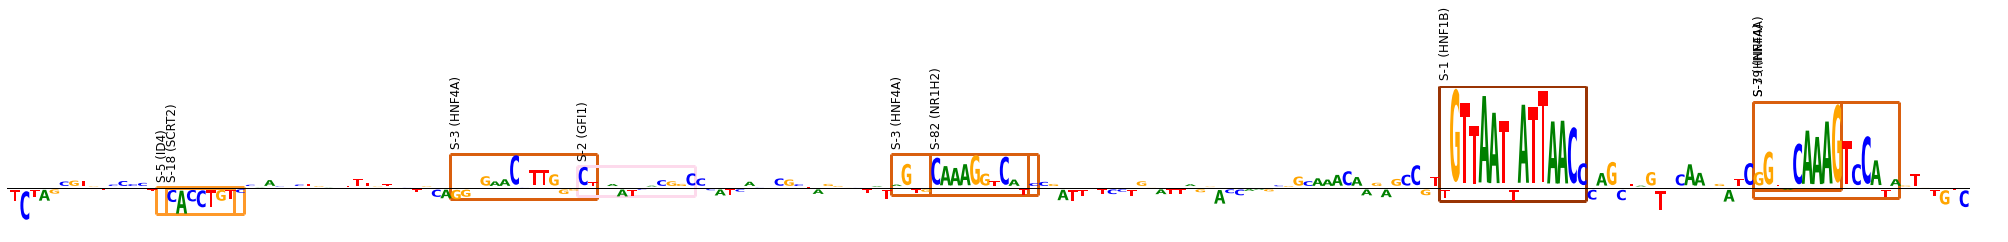

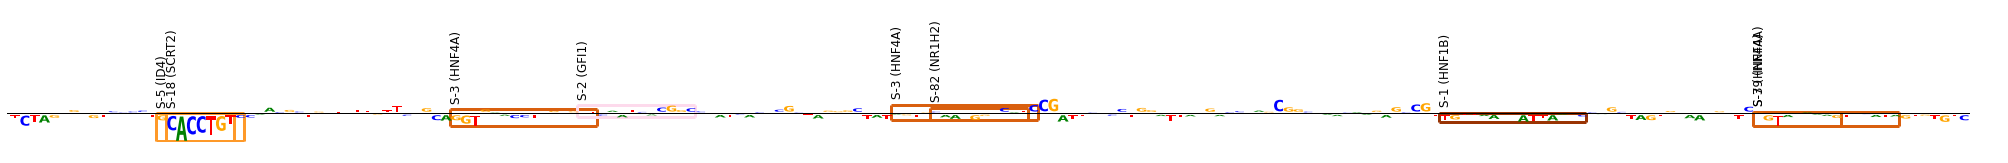



20211212_12620__229779__56::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
66954    -0.438644      5.859807     -0.732171


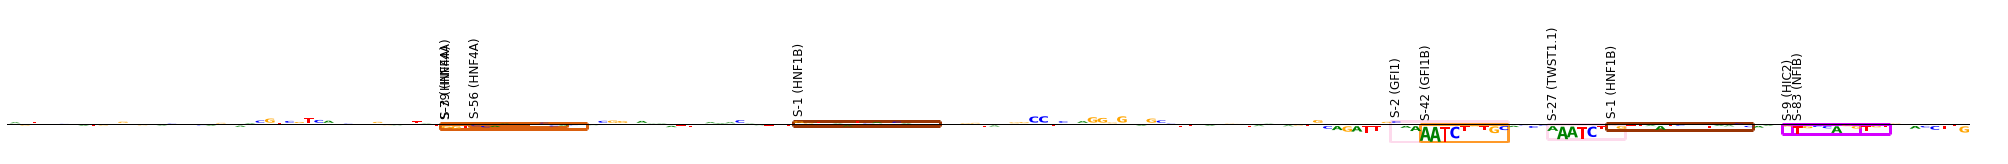

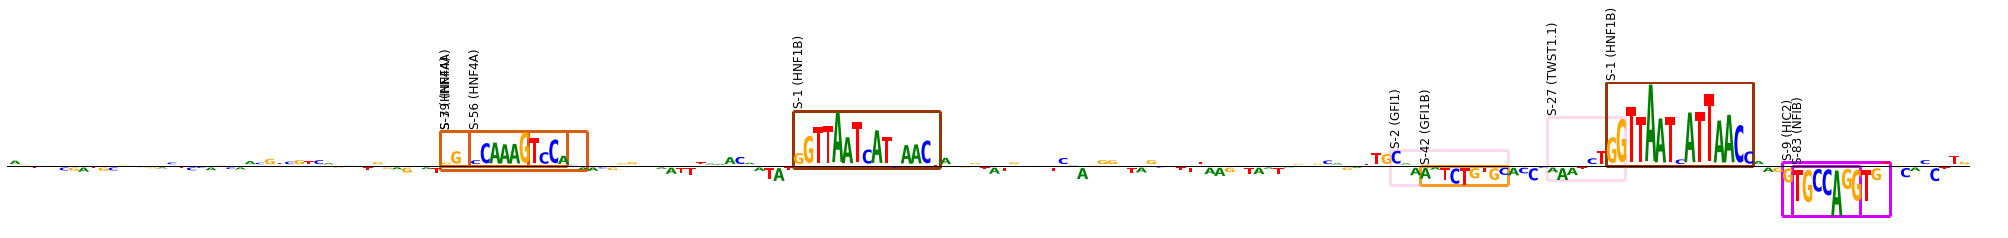

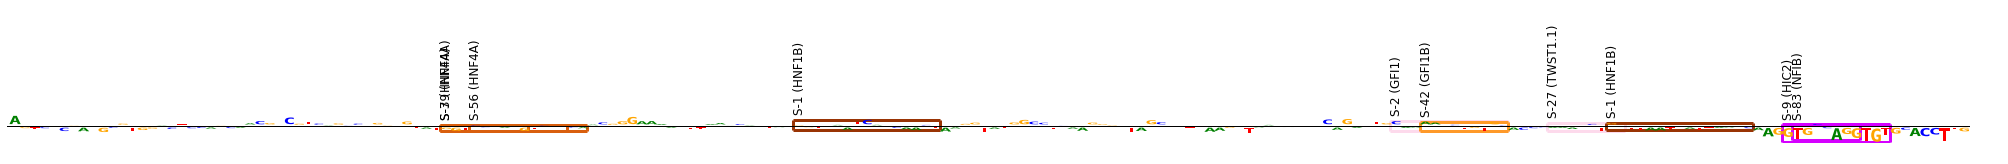

ValueError: ignored

In [ ]:
selected_ids = ['20211212_55149__346635__38::fsp__hepg2__0',
                '20211212_52639__969454__182::fsp__hepg2__0',
                '20211212_12620__229779__1223::fsp__hepg2__0', 
                '20211212_55149__346635__486::fsp__hepg2__0',
                '20211212_55149__346635__150::fsp__hepg2__0',
                '20211212_52639__969454__185::fsp__hepg2__0',
                '20211212_12620__229779__1181::fsp__hepg2__0',
                '20211212_12620__229779__56::fsp__hepg2__0',
                ]

for single_seq_id in selected_ids:
    print(single_seq_id)
    #--- Get sequence and contributions
    single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]
    test_str = single_seq_df['sequence'].item()
    test_onehot = utils.dna2tensor(test_str).view(4,-1)
    contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

    #--- Plot topic assignments
    ax = single_seq_df[program_columns].plot.barh(stacked=True, width=10, figsize=(5,0.25),
                            color=pal, linewidth=0.0, legend=False)
    plt.axis('off')
    plt.show()

    #--- Get FIMO hits
    seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
    seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
    print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])

    seq_contributions = contribution_tensor
    y_max = seq_contributions.max()

    color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
    motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    passing_idxs = []
    all_motif_contributions = []
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

        find_motif_names.append(hit_row['motif_id'])
        motifs_start_ends.append((m_start, m_end))
        orientations.append(hit_row['strand'])
        cover_set = cover_set | motif_range
        passing_idxs.append(i)
        all_motif_contributions.append(motif_contributions)


    #--- Plot contributions and FIMO hits
    for i in range(0,3):
    #i = 1
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        # fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
        #                     heightscale=0.8, fontaspect=0.55)
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
        for idx, motif_name in enumerate(find_motif_names):
            color = color_dict[motif_name]
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0] 
            y = contrib_min_maxs[idx][1] + 0.05  
            plt.text(x, y, text, fontsize=12, rotation=90)  
        plt.axis('off')
        plt.show()  

    print('')
    print('')

20211212_12620__229779__1223::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68121    -0.426471        6.0799     -0.835748


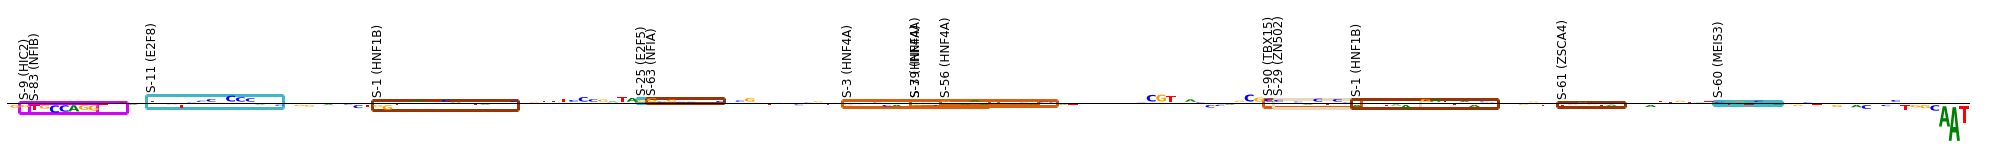

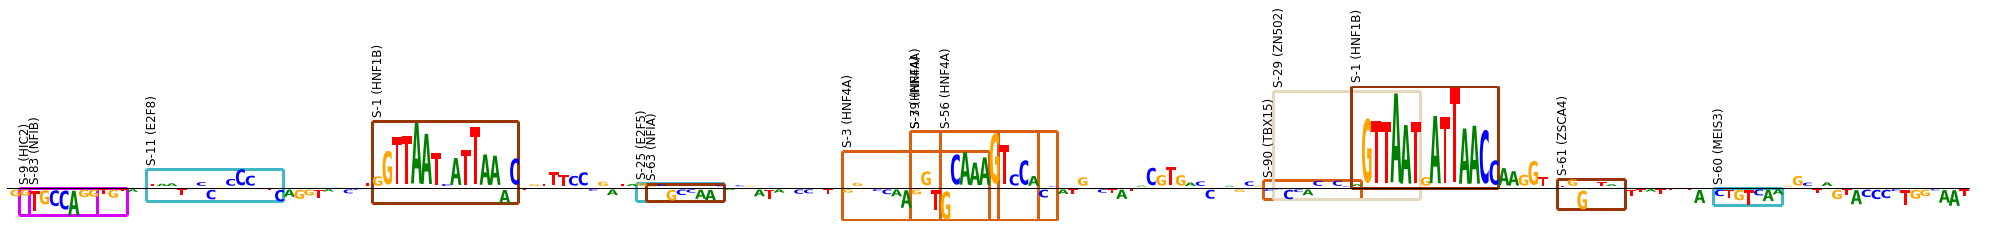

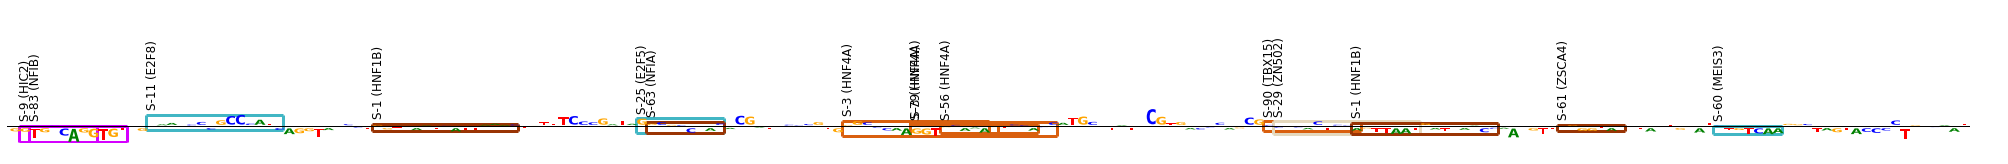



20211212_52639__969454__185::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
70833    -0.787379      5.526433     -2.181965


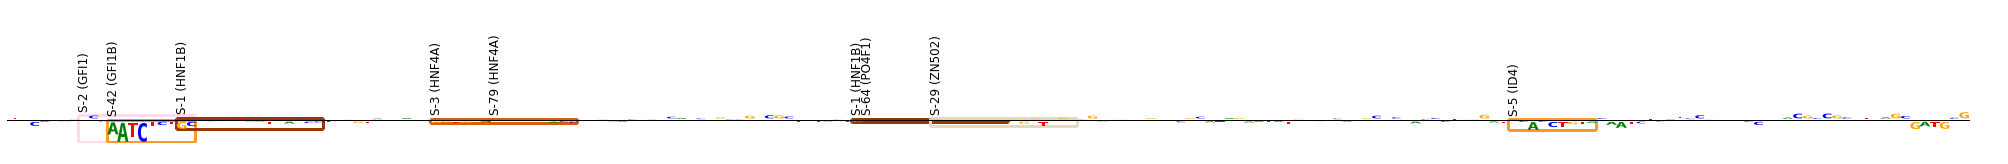

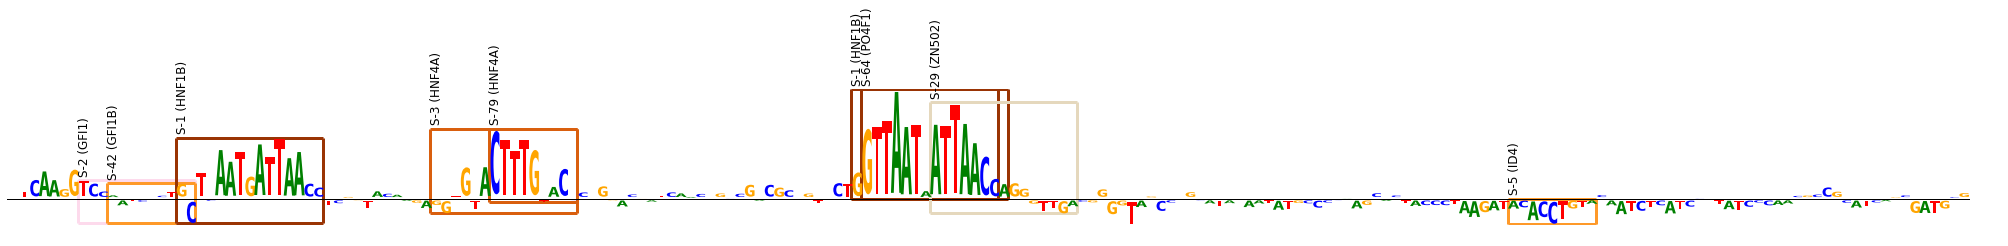

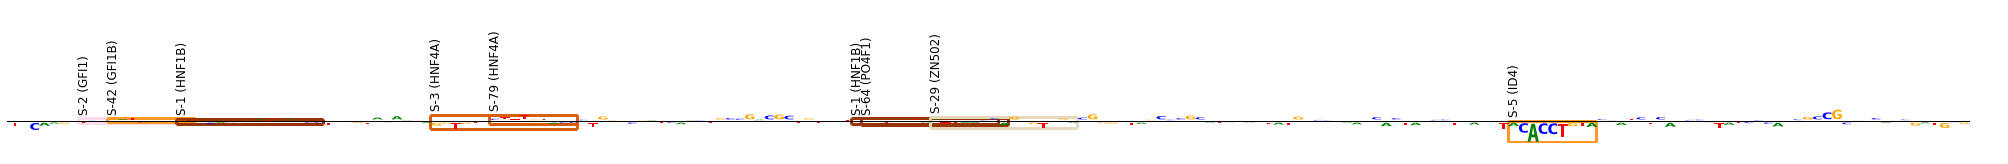



20211212_12620__229779__1181::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
68079    -0.913115      5.545391     -0.767255


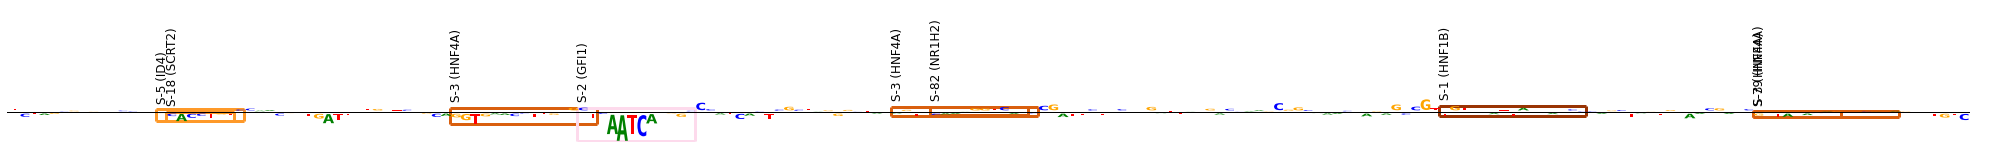

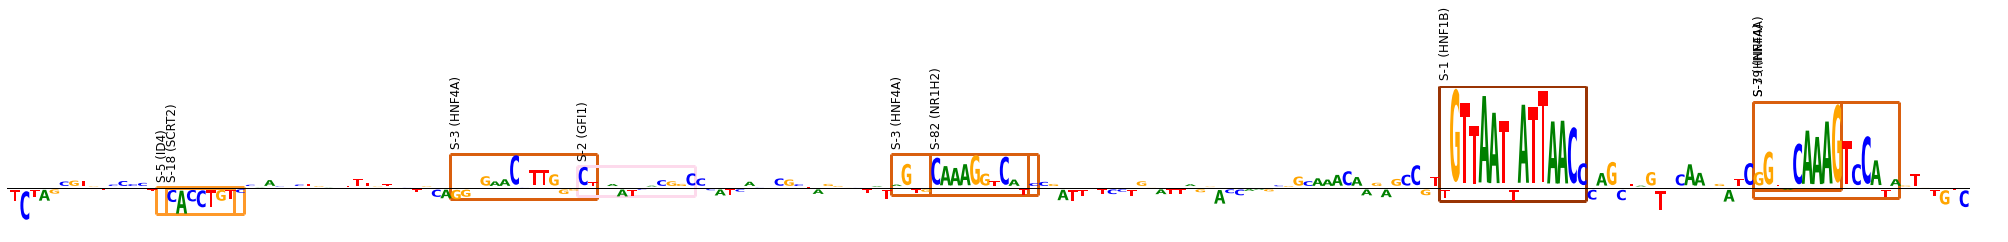

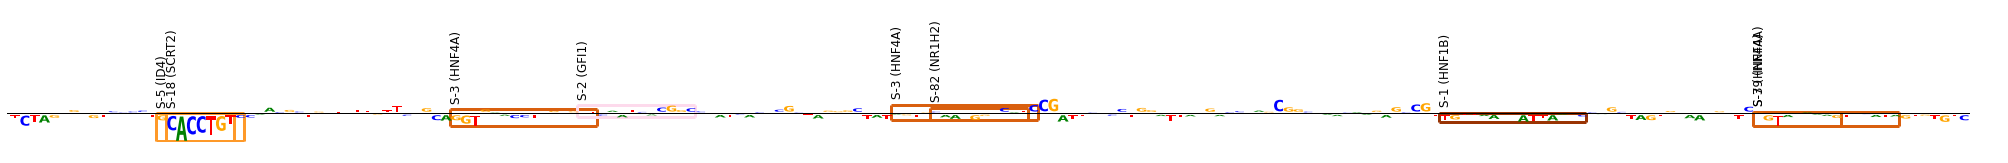



20211212_12620__229779__56::fsp__hepg2__0


       K562_signal  HepG2_signal  SKNSH_signal
66954    -0.438644      5.859807     -0.732171


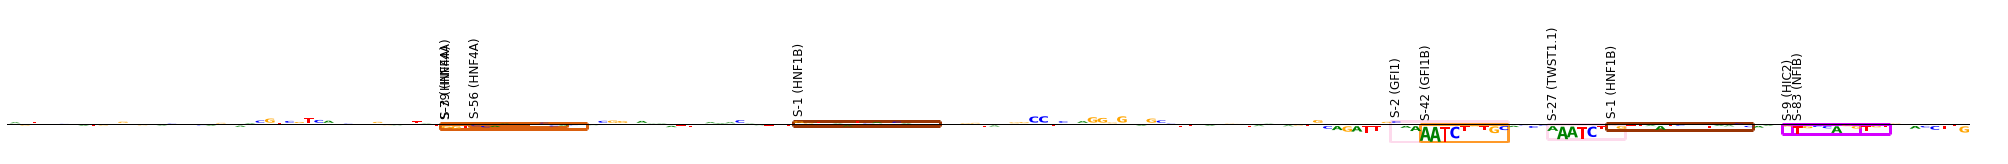

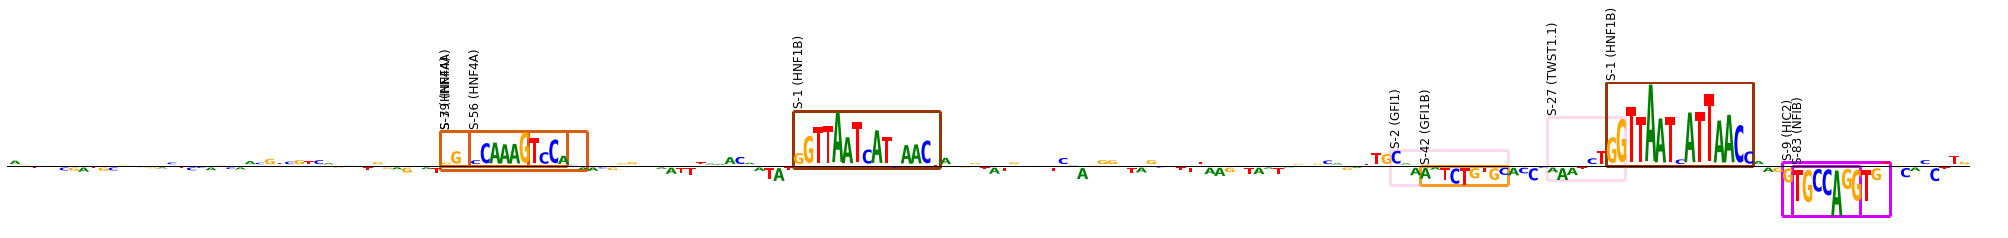

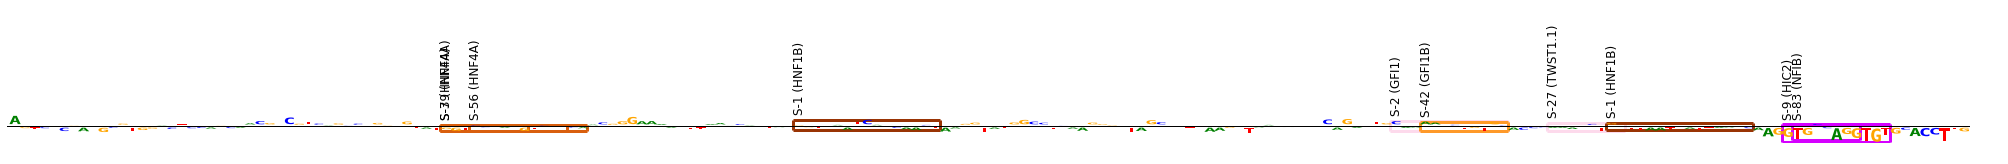

In [ ]:
selected_selected_ids = ['20211212_12620__229779__1223::fsp__hepg2__0',
                         '20211212_52639__969454__185::fsp__hepg2__0',
                         '20211212_12620__229779__1181::fsp__hepg2__0',
                         '20211212_12620__229779__56::fsp__hepg2__0'
                         ]

for single_seq_id in selected_selected_ids:
    print(single_seq_id)
    #--- Get sequence and contributions
    single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]
    test_str = single_seq_df['sequence'].item()
    test_onehot = utils.dna2tensor(test_str).view(4,-1)
    contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

    #--- Plot topic assignments
    ax = single_seq_df[program_columns].plot.barh(stacked=True, width=10, figsize=(5,0.25),
                            color=pal, linewidth=0.0, legend=False)
    plt.axis('off')
    plt.show()

    #--- Get FIMO hits
    seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
    seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
    print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])

    seq_contributions = contribution_tensor
    y_max = seq_contributions.max()

    color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
    motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    passing_idxs = []
    all_motif_contributions = []
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

        find_motif_names.append(hit_row['motif_id'])
        motifs_start_ends.append((m_start, m_end))
        orientations.append(hit_row['strand'])
        cover_set = cover_set | motif_range
        passing_idxs.append(i)
        all_motif_contributions.append(motif_contributions)


    #--- Plot contributions and FIMO hits
    for i in range(0,3):
    #i = 1
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        # fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
        #                     heightscale=0.8, fontaspect=0.55)
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
        for idx, motif_name in enumerate(find_motif_names):
            color = color_dict[motif_name]
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0] 
            y = contrib_min_maxs[idx][1] + 0.05  
            plt.text(x, y, text, fontsize=12, rotation=90)  
        plt.axis('off')
        plt.show()  

    print('')
    print('')

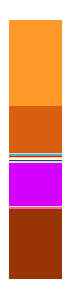


       K562_signal  HepG2_signal  SKNSH_signal
66954    -0.438644      5.859807     -0.732171


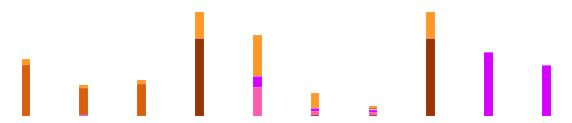

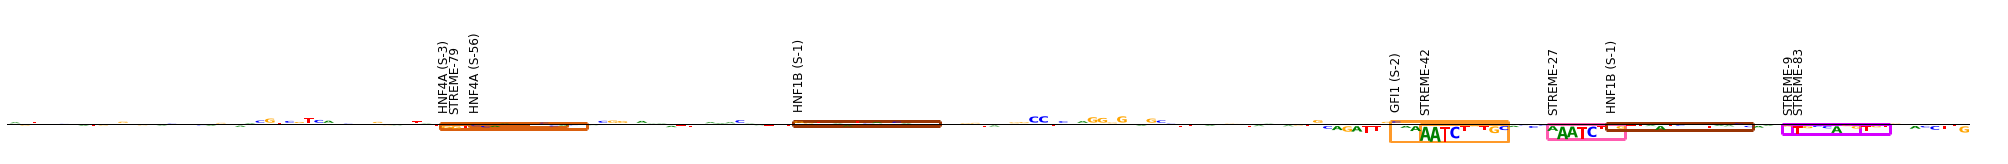

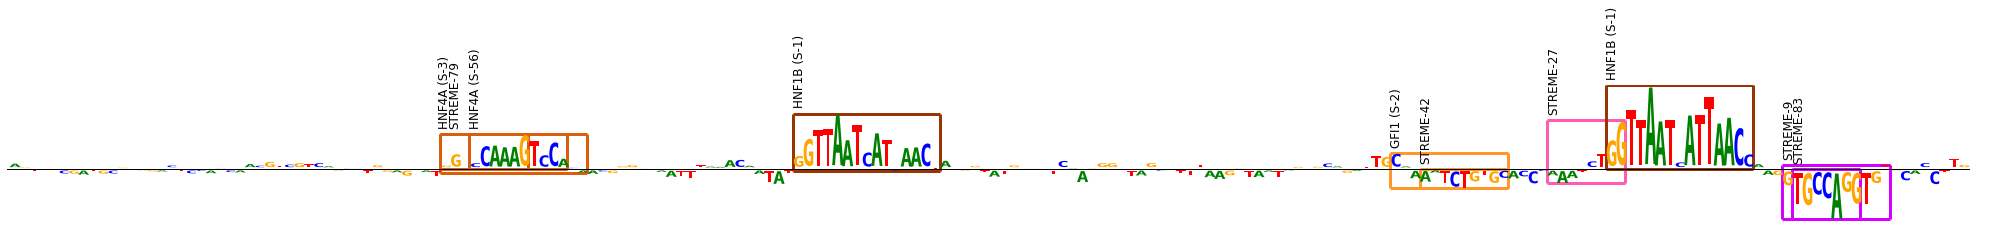

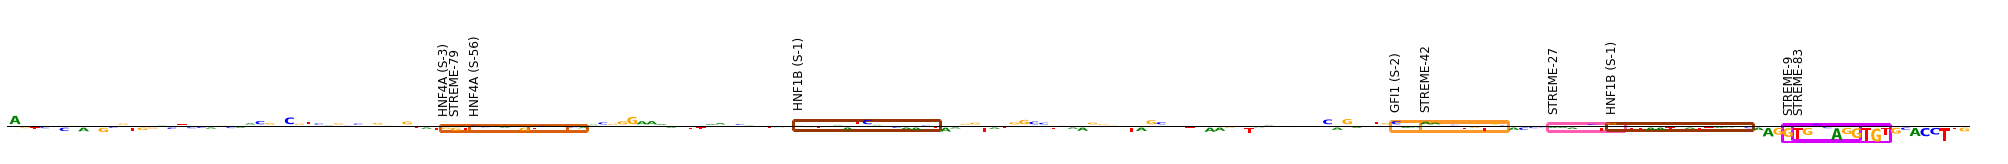

In [ ]:
single_seq_id = '20211212_12620__229779__56::fsp__hepg2__0'

single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]
test_str = single_seq_df['sequence'].item()
test_onehot = utils.dna2tensor(test_str).view(4,-1)
contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

#--- Plot topic assignments
ax = single_seq_df[program_columns].plot.bar(stacked=True, width=10, figsize=(1,5),
                        color=pal, linewidth=0.0, legend=False)
plt.axis('off')
plt.show()

print('')

#--- Get FIMO hits
seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])
motif_ids = seq_scan_df.sort_values('start')['motif_id'].tolist()

temp_array = []
short_names = []
for motif_id in motif_ids:
    temp_array.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id][program_columns].values.reshape(-1))
    short_names.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id]['ultimate_id'].item())
temp_array = np.stack(temp_array)
temp_df = pd.DataFrame(temp_array)

ax = temp_df.plot.bar(stacked=True, 
                    figsize=(10,2), 
                    width=0.15,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='white', 
                    linewidth=0.1,
                    legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_xticklabels(short_names, rotation=90, ha='right', fontsize=12)
ax.set_xticklabels([])
#ax.legend(bbox_to_anchor=(1.08, 1), fontsize='medium', labelspacing=0.1, frameon=False)
#plt.title('Present motifs', fontsize=24)
plt.yticks([])
plt.axis('off')
plt.show()

print('')

seq_contributions = contribution_tensor
y_max = seq_contributions.max()

color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['ultimate_id']))

find_motif_names  = []
motifs_start_ends = []
orientations      = []
cover_set         = set()
passing_idxs = []
all_motif_contributions = []
num_hits = len(seq_scan_df)
for i in range(num_hits):
    hit_row = seq_scan_df.iloc[i]
    m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
    motif_range = set(np.arange(m_start, m_end))
    motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
    pos_contribution = motif_contributions.max()
    neg_contribution = motif_contributions.min()
    contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

    find_motif_names.append(hit_row['motif_id'])
    motifs_start_ends.append((m_start, m_end))
    orientations.append(hit_row['strand'])
    cover_set = cover_set | motif_range
    passing_idxs.append(i)
    all_motif_contributions.append(motif_contributions)


#--- Plot contributions and FIMO hits
for i in range(0,3):
    #i = 1
    matrix_plot = seq_contributions[i, ...]
    contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                        for m_start, m_end in motifs_start_ends]
    # fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
    #                     heightscale=0.8, fontaspect=0.55)
    fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                        fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
    for idx, motif_name in enumerate(find_motif_names):
        color = color_dict[motif_name]
        plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

        text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
        if idx == 0:
            x = motifs_start_ends[idx][0] - 0.25
        elif idx == 1:
            x = motifs_start_ends[idx][0] + 0.85
        elif idx == 9:
            x = motifs_start_ends[idx][0] + 0.1
        else:
            x = motifs_start_ends[idx][0] 
        y = contrib_min_maxs[idx][1] + 0.08 #- 0.06 * len(text)
        plt.text(x, y, text, fontsize=12, rotation=90)  
    plt.axis('off')
    plt.show()  

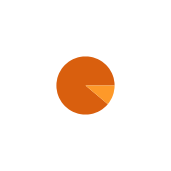

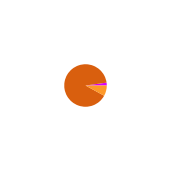

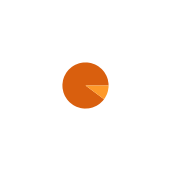

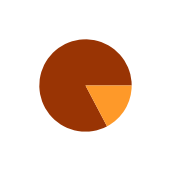

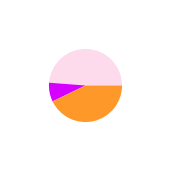

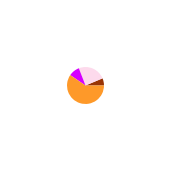

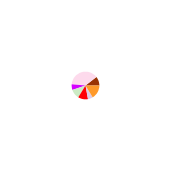

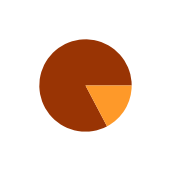

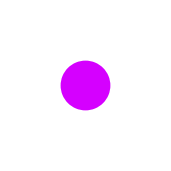

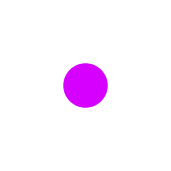

In [ ]:
for j in range(num_hits):
    temp_weights = temp_df.iloc[j].to_numpy()
    original_sum = temp_weights.sum()
    temp_weights = temp_weights/original_sum

    plt.figure(figsize=(2,2), dpi=100)
    plt.pie(x=temp_weights, colors=pal, radius=original_sum**0.5)
    plt.show()

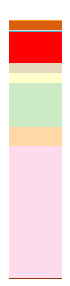


       K562_signal  HepG2_signal  SKNSH_signal
90789    -0.866327     -0.314954      4.515997


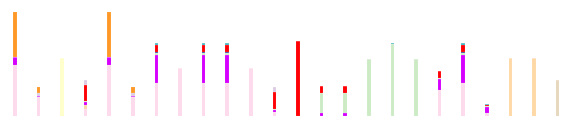

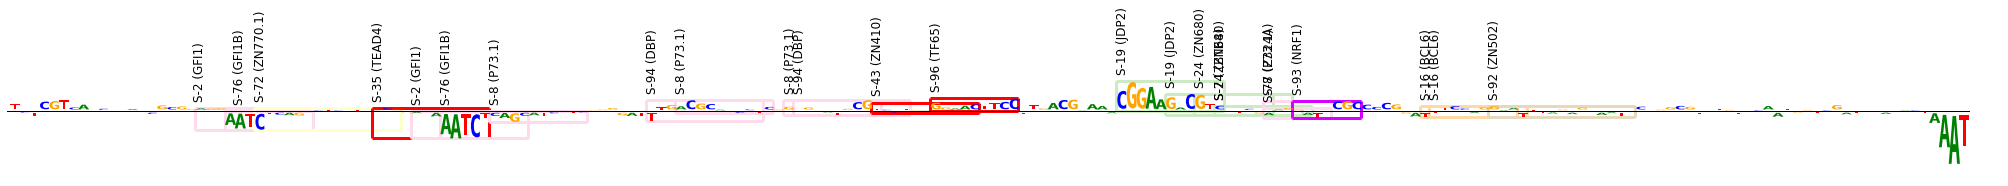

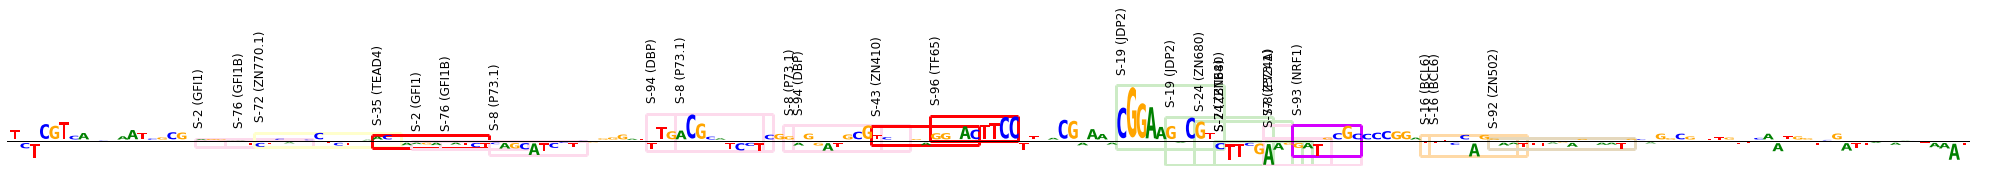

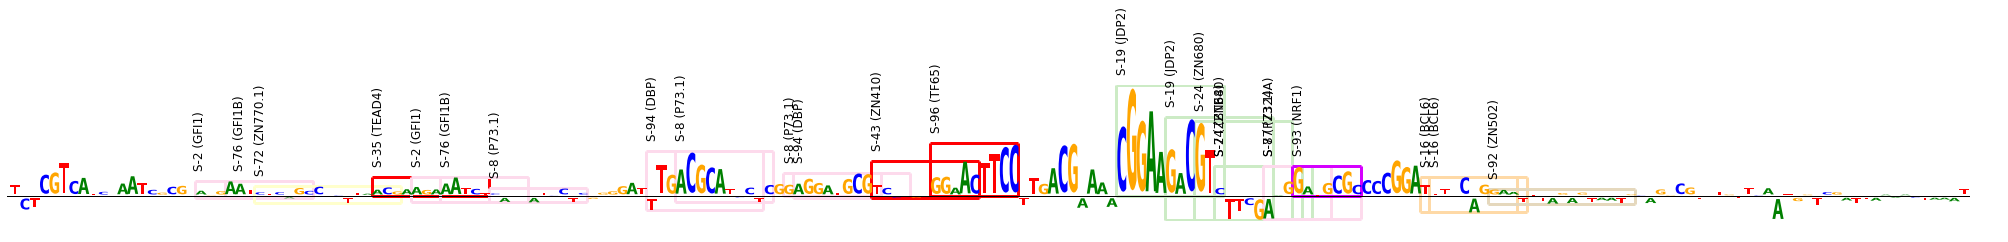

In [ ]:
single_seq_id = '20211212_75659__621411__391::fsp__sknsh__0'

single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]
test_str = single_seq_df['sequence'].item()
test_onehot = utils.dna2tensor(test_str).view(4,-1)
contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

#--- Plot topic assignments
ax = single_seq_df[program_columns].plot.bar(stacked=True, width=10, figsize=(1,5),
                        color=pal, linewidth=0.0, legend=False)
plt.axis('off')
plt.show()

print('')

#--- Get FIMO hits
seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])
motif_ids = seq_scan_df.sort_values('start')['motif_id'].tolist()

temp_array = []
short_names = []
for motif_id in motif_ids:
    temp_array.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id][program_columns].values.reshape(-1))
    short_names.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id]['Target_ID_short'].item())
temp_array = np.stack(temp_array)
temp_df = pd.DataFrame(temp_array)

ax = temp_df.plot.bar(stacked=True, 
                    figsize=(10,2), 
                    width=0.15,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='white', 
                    linewidth=0.1,
                    legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_xticklabels(short_names, rotation=90, ha='right', fontsize=12)
ax.set_xticklabels([])
#ax.legend(bbox_to_anchor=(1.08, 1), fontsize='medium', labelspacing=0.1, frameon=False)
#plt.title('Present motifs', fontsize=24)
plt.yticks([])
plt.axis('off')
plt.show()

print('')

seq_contributions = contribution_tensor
y_max = seq_contributions.max()

color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

find_motif_names  = []
motifs_start_ends = []
orientations      = []
cover_set         = set()
passing_idxs = []
all_motif_contributions = []
num_hits = len(seq_scan_df)
for i in range(num_hits):
    hit_row = seq_scan_df.iloc[i]
    m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
    motif_range = set(np.arange(m_start, m_end))
    motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
    pos_contribution = motif_contributions.max()
    neg_contribution = motif_contributions.min()
    contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

    find_motif_names.append(hit_row['motif_id'])
    motifs_start_ends.append((m_start, m_end))
    orientations.append(hit_row['strand'])
    cover_set = cover_set | motif_range
    passing_idxs.append(i)
    all_motif_contributions.append(motif_contributions)


#--- Plot contributions and FIMO hits
for i in range(0,3):
#i = 2
    matrix_plot = seq_contributions[i, ...]
    contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                        for m_start, m_end in motifs_start_ends]
    # fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
    #                     heightscale=0.8, fontaspect=0.55)
    fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                        fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
    for idx, motif_name in enumerate(find_motif_names):
        color = color_dict[motif_name]
        plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

        text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
        if idx == 0:
            x = motifs_start_ends[idx][0] - 0.25
        elif idx == 1:
            x = motifs_start_ends[idx][0] + 0.85
        elif idx == 9:
            x = motifs_start_ends[idx][0] + 0.1
        else:
            x = motifs_start_ends[idx][0] 
        y = contrib_min_maxs[idx][1] + 0.08 #- 0.06 * len(text)
        plt.text(x, y, text, fontsize=12, rotation=90)  
    plt.axis('off')
    plt.show()  

# for j in range(num_hits):
#     temp_weights = temp_df.iloc[j].to_numpy()
#     original_sum = temp_weights.sum()
#     temp_weights = temp_weights/original_sum

#     plt.figure(figsize=(2,2), dpi=100)
#     plt.pie(x=temp_weights, colors=pal, radius=original_sum**0.5)
#     plt.show()

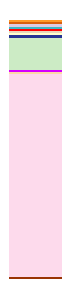


       K562_signal  HepG2_signal  SKNSH_signal
65181    -0.356682     -0.227919      2.857992


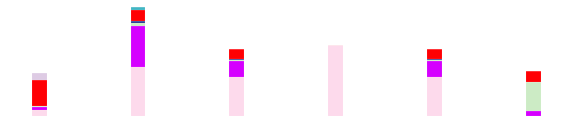

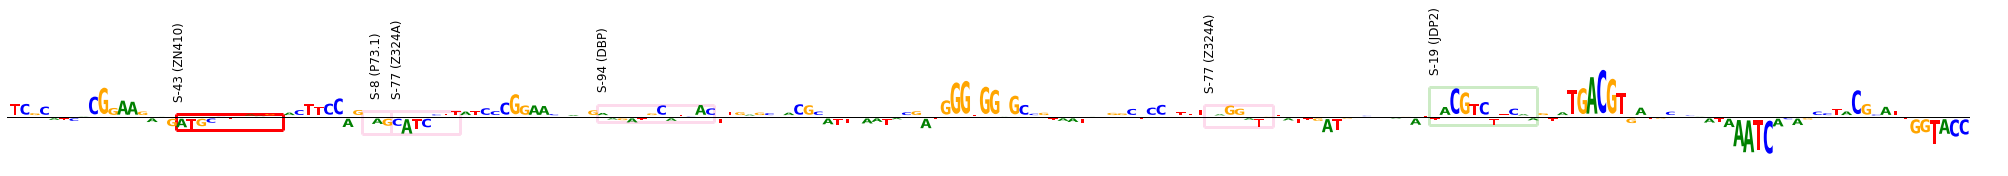

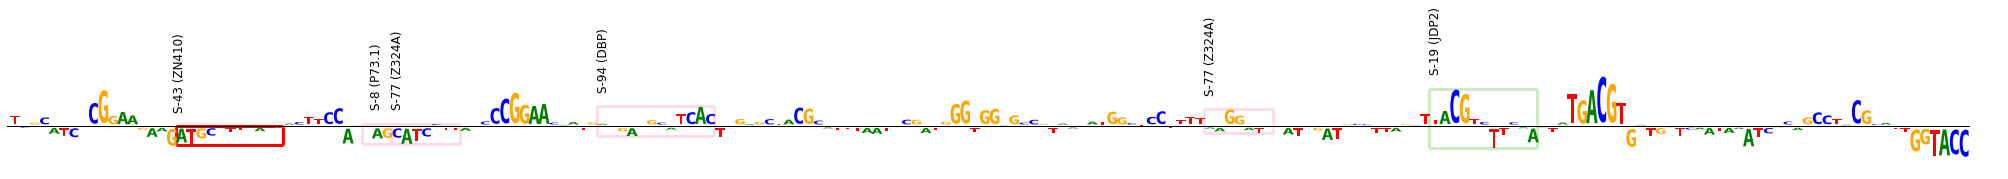

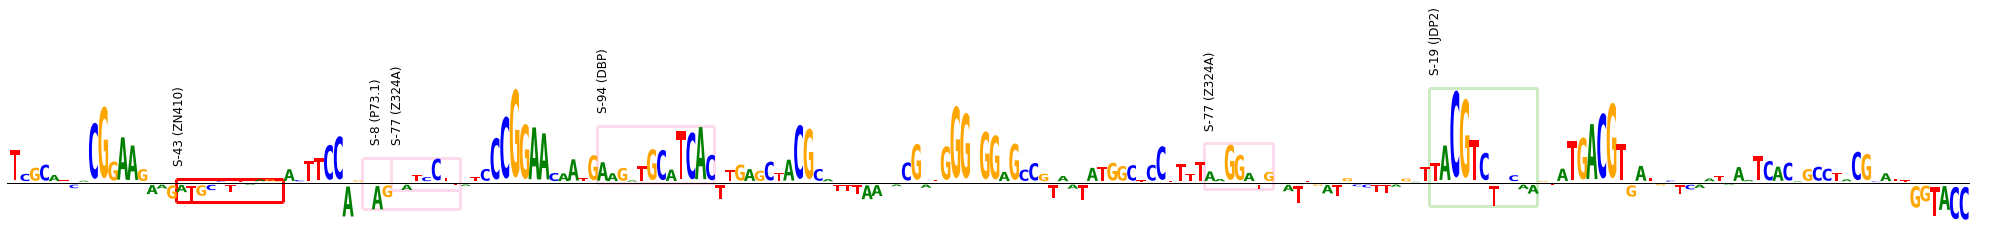

In [ ]:
single_seq_id = '20211207_212124__46481152__2927::al__sknsh__0'

single_seq_df = merged_seq_df[merged_seq_df['ID'] == single_seq_id]
test_str = single_seq_df['sequence'].item()
test_onehot = utils.dna2tensor(test_str).view(4,-1)
contribution_tensor = torch.stack([str2tensor(single_seq_df[contribution_column].item()).repeat(4,1) * test_onehot for contribution_column in contribution_columns])

#--- Plot topic assignments
ax = single_seq_df[program_columns].plot.bar(stacked=True, width=10, figsize=(1,5),
                        color=pal, linewidth=0.0, legend=False)
plt.axis('off')
plt.show()

print('')

#--- Get FIMO hits
seq_scan_df = fimo_df[fimo_df['sequence_name'] == single_seq_id].sort_values('start')[:-1]
seq_scan_df = seq_scan_df[~seq_scan_df[['motif_id', 'start', 'stop']].duplicated()]
print(single_seq_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']])
motif_ids = seq_scan_df.sort_values('start')['motif_id'].tolist()

temp_array = []
short_names = []
for motif_id in motif_ids:
    temp_array.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id][program_columns].values.reshape(-1))
    short_names.append(merged_tf_df[merged_tf_df['motif_id'] == motif_id]['Target_ID_short'].item())
temp_array = np.stack(temp_array)
temp_df = pd.DataFrame(temp_array)

ax = temp_df.plot.bar(stacked=True, 
                    figsize=(10,2), 
                    width=0.15,
                    color=pal, 
                    fontsize='x-small',
                    edgecolor='white', 
                    linewidth=0.1,
                    legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_xticklabels(short_names, rotation=90, ha='right', fontsize=12)
ax.set_xticklabels([])
#ax.legend(bbox_to_anchor=(1.08, 1), fontsize='medium', labelspacing=0.1, frameon=False)
#plt.title('Present motifs', fontsize=24)
plt.yticks([])
plt.axis('off')
plt.show()

print('')

seq_contributions = contribution_tensor
y_max = seq_contributions.max()

color_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['color']))
motif_short_names_dict = dict(zip(merged_tf_df['motif_id'], merged_tf_df['Target_ID_short']))

find_motif_names  = []
motifs_start_ends = []
orientations      = []
cover_set         = set()
passing_idxs = []
all_motif_contributions = []
num_hits = len(seq_scan_df)
for i in range(num_hits):
    hit_row = seq_scan_df.iloc[i]
    m_start, m_end = int(hit_row['start'] - 1), int(hit_row['stop'])
    motif_range = set(np.arange(m_start, m_end))
    motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
    pos_contribution = motif_contributions.max()
    neg_contribution = motif_contributions.min()
    contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)

    find_motif_names.append(hit_row['motif_id'])
    motifs_start_ends.append((m_start, m_end))
    orientations.append(hit_row['strand'])
    cover_set = cover_set | motif_range
    passing_idxs.append(i)
    all_motif_contributions.append(motif_contributions)


#--- Plot contributions and FIMO hits
for i in range(0,3):
#i = 2
    matrix_plot = seq_contributions[i, ...]
    contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                        for m_start, m_end in motifs_start_ends]
    # fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
    #                     heightscale=0.8, fontaspect=0.55)
    fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                        fontaspect=0.5, widthscale=0.5, axisfontscale=0.6, heightscale=1)
    for idx, motif_name in enumerate(find_motif_names):
        color = color_dict[motif_name]
        plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
        plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

        text = f'{motif_short_names_dict[motif_name]}'#' ({motif_pct_select[idx]}%)'
        if idx == 0:
            x = motifs_start_ends[idx][0] - 0.25
        elif idx == 1:
            x = motifs_start_ends[idx][0] + 0.85
        elif idx == 9:
            x = motifs_start_ends[idx][0] + 0.1
        else:
            x = motifs_start_ends[idx][0] 
        y = contrib_min_maxs[idx][1] + 0.08 #- 0.06 * len(text)
        plt.text(x, y, text, fontsize=12, rotation=90)  
    plt.axis('off')
    plt.show()  

# for j in range(num_hits):
#     temp_weights = temp_df.iloc[j].to_numpy()
#     original_sum = temp_weights.sum()
#     temp_weights = temp_weights/original_sum

#     plt.figure(figsize=(2,2), dpi=100)
#     plt.pie(x=temp_weights, colors=pal, radius=original_sum**0.5)
#     plt.show()